# MT5 Trade Analysis

This notebook analyzes trading data exported from MetaTrader 5 (MT5) for the EUR/GBP currency pair. The data is loaded from the Excel file `deals eurgbp.xlsx`, located in the `/home/edocame/Desktop/data_python/` directory.

## Table of Contents

1. [Data Loading](#1-data-loading)
2. [Outlier Detection](#2-outlier-detection)
3. [Trade Duration Calculation](#3-trade-duration-calculation)
4. [Profit vs Duration Analysis](#4-profit-vs-duration-analysis)
5. [Profit Distribution by Duration](#5-profit-distribution-by-duration)
6. [Profits/Losses by Duration Bin](#6-profitslosses-by-duration-bin)
7. [Profits/Losses by Duration Bin (<=500min)](#7-profitslosses-by-duration-bin-500min)
8. [Profit/Loss Size Distribution (<=500min)](#8-profitloss-size-distribution-500min)

---

## Data Source
- **File:** `deals eurgbp.xlsx`
- **Origin:** Exported from MetaTrader 5 (MT5).
- **Instrument:** EUR/GBP
- **Date range**: 2024-11-01 00:05:00 to 2025-06-24 23:58:59

## Data Description
The dataset contains detailed trade records, including columns such as:
- `Time`: Timestamp of each trade event
- `Direction`: Trade direction (e.g., 'in' for entry, 'out' for exit)
- `Profit`: Profit or loss for each trade
- Other trade-related fields

## Notebook Purpose
The notebook explores the structure of the trading data, identifies outliers in trade profits using z-score analysis, and investigates the relationship between trade duration and profit. It includes data visualization and statistical analysis to better understand trading performance and patterns.

In [1]:
# 1. Data Loading

data_path = '/home/edocame/Desktop/data_python/deals eurgbp.xlsx'

import pandas as pd

# Leggi il file Excel usando pandas e openpyxl
df = pd.read_excel(data_path, engine='openpyxl')
df = df.iloc[1:].reset_index(drop=True)
df.head()

,Time,Deal,Symbol,Type,Direction,Volume,Price,Order,Commission,Swap,Profit,Balance,Comment
0,2024.11.01 00:05:00,2,EURGBP.sml,sell,in,0.1,0.84377,2.0,0,0,0.0,10000.0,BB Short Entry
1,2024.11.01 11:11:40,3,EURGBP.sml,buy,out,0.1,0.84199,3.0,0,0,17.8,10017.8,tp 0.84199
2,2024.11.01 15:09:00,4,EURGBP.sml,buy,in,0.1,0.84100,4.0,0,0,0.0,10017.8,BB Long Entry
3,2024.11.04 09:49:39,5,EURGBP.sml,sell,out,0.1,0.83940,5.0,0,0,-16.0,10001.8,tp 0.83940
4,2024.11.04 11:01:00,6,EURGBP.sml,sell,in,0.1,0.84046,6.0,0,0,0.0,10001.8,BB Short Entry


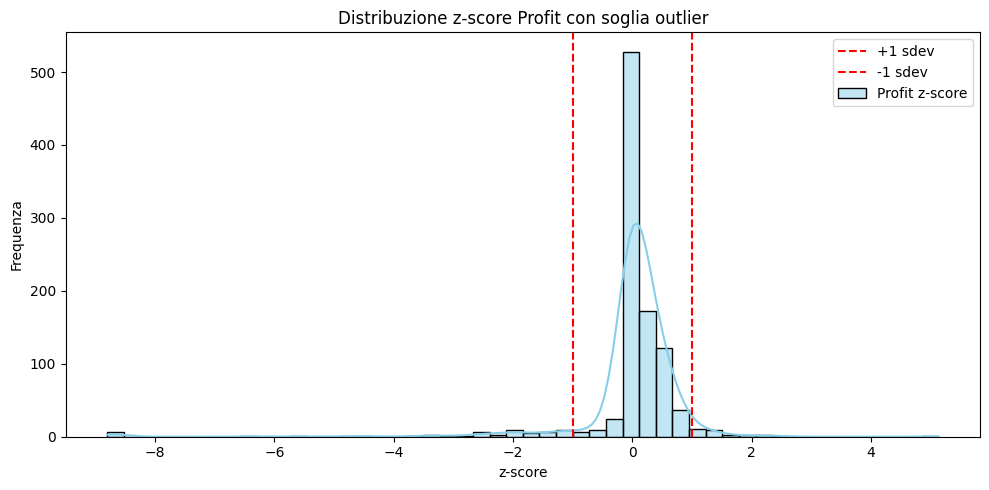

In [2]:
# 2. Outlier Detection

# Soglia z-score per determinare gli outlier
z_threshold = 1  # Cambia questo valore per scegliere la soglia desiderata

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Visualizza la distribuzione del Profit con evidenza degli outlier
profit_z = zscore(df['Profit'].dropna())
plt.figure(figsize=(10, 5))
sns.histplot(profit_z, bins=50, kde=True, color='skyblue', label='Profit z-score')
plt.axvline(z_threshold, color='red', linestyle='--', label=f'+{z_threshold} sdev')
plt.axvline(-z_threshold, color='red', linestyle='--', label=f'-{z_threshold} sdev')
plt.title('Distribuzione z-score Profit con soglia outlier')
plt.xlabel('z-score')
plt.ylabel('Frequenza')
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# 3. Trade Duration Calculation

# Esplora la struttura e il contenuto del DataFrame
df.info()
df.describe(include='all')
df.head()

# Calcola la durata del trade in minuti (approssimata alla prima cifra decimale)
import pandas as pd

df['Time'] = pd.to_datetime(df['Time'], format='%Y.%m.%d %H:%M:%S')
trade_durations = []
for i in range(1, len(df)):
    if df.loc[i, 'Direction'] == 'out' and df.loc[i-1, 'Direction'] == 'in':
        duration = (df.loc[i, 'Time'] - df.loc[i-1, 'Time']).total_seconds() / 60
        trade_durations.append(round(duration, 1))
    else:
        trade_durations.append(None)
df['Trade_Duration'] = [None] + trade_durations
df[['Time', 'Direction', 'Trade_Duration']].head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Time        980 non-null    object 
 1   Deal        980 non-null    int64  
 2   Symbol      980 non-null    object 
 3   Type        980 non-null    object 
 4   Direction   980 non-null    object 
 5   Volume      980 non-null    float64
 6   Price       980 non-null    float64
 7   Order       980 non-null    float64
 8   Commission  980 non-null    int64  
 9   Swap        980 non-null    int64  
 10  Profit      980 non-null    float64
 11  Balance     980 non-null    float64
 12  Comment     788 non-null    object 
dtypes: float64(5), int64(3), object(5)
memory usage: 99.7+ KB


,Time,Direction,Trade_Duration
0,2024-11-01 00:05:00,in,NaN
1,2024-11-01 11:11:40,out,666.7
2,2024-11-01 15:09:00,in,NaN
3,2024-11-04 09:49:39,out,4000.7
4,2024-11-04 11:01:00,in,NaN
5,2024-11-04 17:11:00,out,370.0
6,2024-11-04 18:09:00,in,NaN
7,2024-11-04 21:51:00,out,222.0
8,2024-11-05 07:21:00,in,NaN
9,2024-11-05 20:38:05,out,797.1


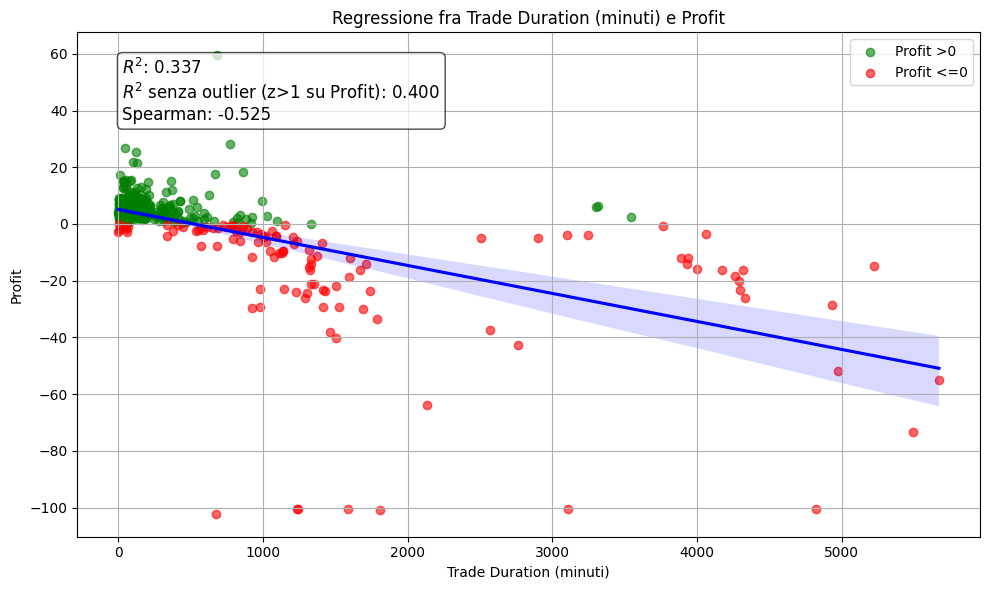

In [4]:
# 4. Profit vs Duration Analysis

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, zscore

# Filtra solo le righe con valori validi
plot_df = df[(df['Trade_Duration'].notnull()) & (df['Profit'].notnull())].copy()

# Crea una colonna colore: verde se profit > 0, rosso se <= 0
plot_df['color'] = plot_df['Profit'].apply(lambda x: 'green' if x > 0 else 'red')

# Calcola R2 della regressione lineare
X = plot_df['Trade_Duration'].values.reshape(-1, 1)
y = plot_df['Profit'].values
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
r2 = r2_score(y, y_pred)

# Calcola coefficiente di correlazione di Spearman
spearman_corr, spearman_p = spearmanr(plot_df['Trade_Duration'], plot_df['Profit'])

# Calcola R2 senza outlier (usando z_threshold solo su Profit)
plot_df['z_profit'] = zscore(plot_df['Profit'])
no_outliers = plot_df[plot_df['z_profit'].abs() <= z_threshold]
X_no = no_outliers['Trade_Duration'].values.reshape(-1, 1)
y_no = no_outliers['Profit'].values
reg_no = LinearRegression().fit(X_no, y_no)
y_pred_no = reg_no.predict(X_no)
r2_no = r2_score(y_no, y_pred_no)

plt.figure(figsize=(10, 6))
# Scatter colorato manualmente
for color in ['green', 'red']:
    subset = plot_df[plot_df['color'] == color]
    plt.scatter(subset['Trade_Duration'], subset['Profit'], c=color, label=f'Profit {">0" if color=="green" else "<=0"}', alpha=0.6)
# Linea di regressione (senza colore dei punti)
sns.regplot(x='Trade_Duration', y='Profit', data=plot_df, scatter=False, line_kws={'color':'blue', 'label':'Regressione'})
plt.title('Regressione fra Trade Duration (minuti) e Profit')
plt.xlabel('Trade Duration (minuti)')
plt.ylabel('Profit')
# Mostra R2 e Spearman sul grafico
plt.text(0.05, 0.95, f'$R^2$: {r2:.3f}\n$R^2$ senza outlier (z>{z_threshold} su Profit): {r2_no:.3f}\nSpearman: {spearman_corr:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_20195/3059210256.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=pd.cut(plot_df['Trade_Duration'], bins=10), y=plot_df['Profit'], inner='quartile', palette='Set2')


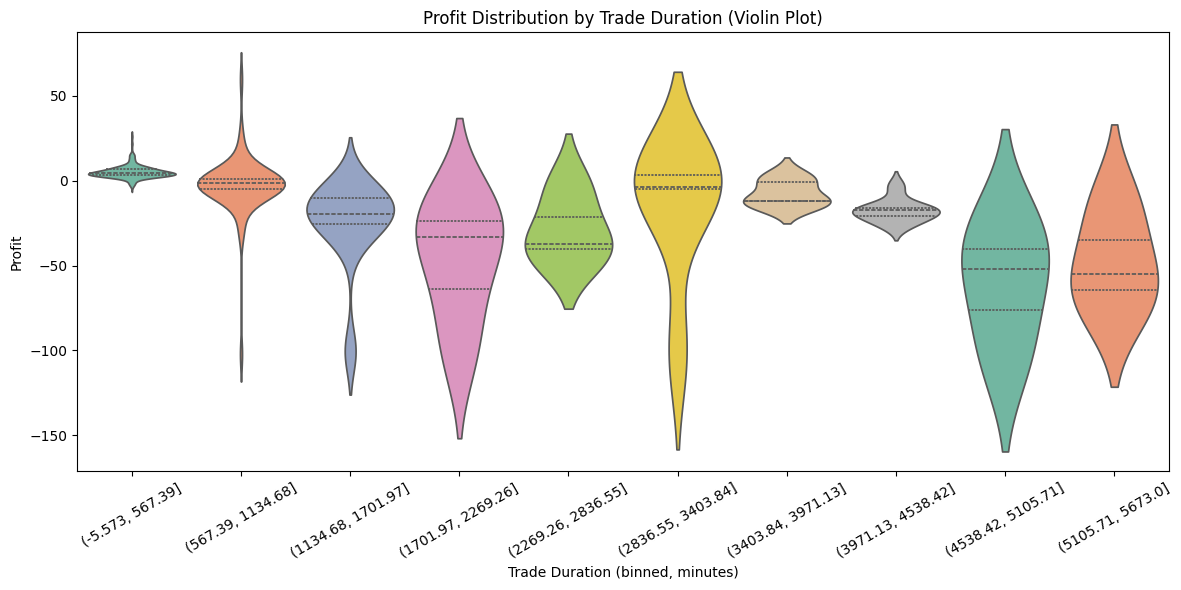

/tmp/ipykernel_20195/3059210256.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pd.cut(plot_df['Trade_Duration'], bins=10), y=plot_df['Profit'], palette='Set3')


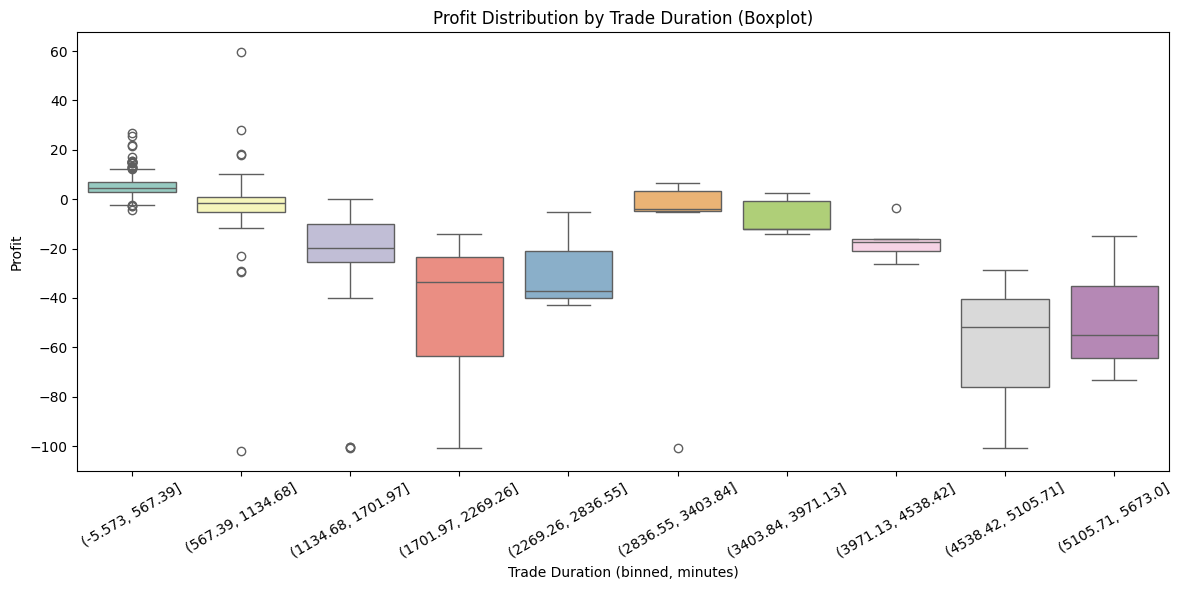

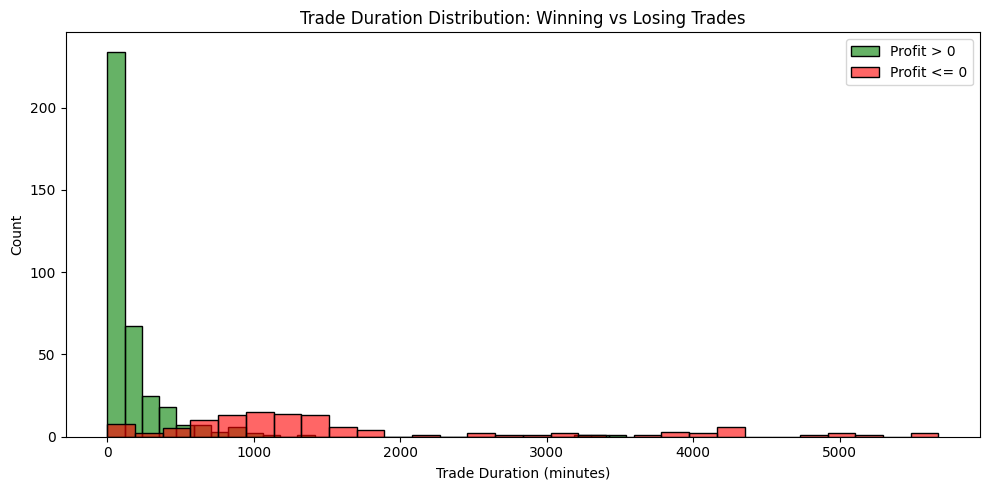

In [5]:
# 5. Profit Distribution by Duration

# Violin plot: Profit distribution by binned trade duration
plt.figure(figsize=(12, 6))
sns.violinplot(x=pd.cut(plot_df['Trade_Duration'], bins=10), y=plot_df['Profit'], inner='quartile', palette='Set2')
plt.title('Profit Distribution by Trade Duration (Violin Plot)')
plt.xlabel('Trade Duration (binned, minutes)')
plt.ylabel('Profit')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Boxplot: Profit by binned trade duration
plt.figure(figsize=(12, 6))
sns.boxplot(x=pd.cut(plot_df['Trade_Duration'], bins=10), y=plot_df['Profit'], palette='Set3')
plt.title('Profit Distribution by Trade Duration (Boxplot)')
plt.xlabel('Trade Duration (binned, minutes)')
plt.ylabel('Profit')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Histogram: Trade duration for winning vs losing trades
plt.figure(figsize=(10, 5))
sns.histplot(plot_df[plot_df['Profit'] > 0]['Trade_Duration'], bins=30, color='green', label='Profit > 0', alpha=0.6)
sns.histplot(plot_df[plot_df['Profit'] <= 0]['Trade_Duration'], bins=30, color='red', label='Profit <= 0', alpha=0.6)
plt.title('Trade Duration Distribution: Winning vs Losing Trades')
plt.xlabel('Trade Duration (minutes)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_20195/4292350902.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  profit_counts_500 = plot_df_500.groupby('duration_bin')['Profit'].apply(lambda x: (x > 0).sum())
/tmp/ipykernel_20195/4292350902.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loss_counts_500 = plot_df_500.groupby('duration_bin')['Profit'].apply(lambda x: (x <= 0).sum())


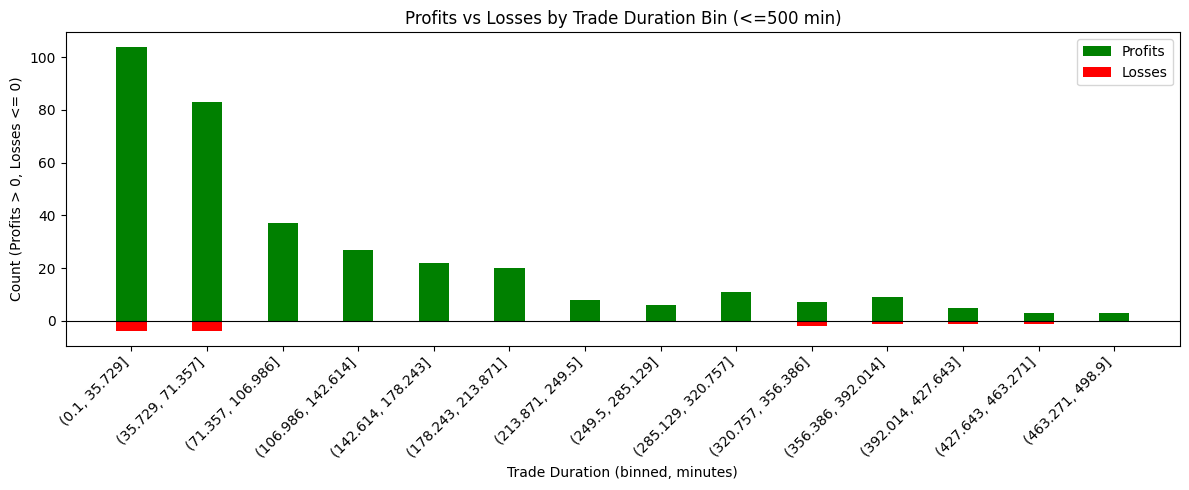

In [6]:
# 7. Profits/Losses by Duration Bin (<=500min)

# Profit/Loss distribution for trades with duration <= 500 minutes
import numpy as np

max_duration = 500
plot_df_500 = plot_df[plot_df['Trade_Duration'] <= max_duration].copy()

# Bin trade durations
bins_500 = np.linspace(plot_df_500['Trade_Duration'].min(), plot_df_500['Trade_Duration'].max(), 15)
plot_df_500['duration_bin'] = pd.cut(plot_df_500['Trade_Duration'], bins_500)

# Count profits and losses per bin
profit_counts_500 = plot_df_500.groupby('duration_bin')['Profit'].apply(lambda x: (x > 0).sum())
loss_counts_500 = plot_df_500.groupby('duration_bin')['Profit'].apply(lambda x: (x <= 0).sum())

# Bar plot: Profits vs Losses by trade duration bin (<=500 min)
plt.figure(figsize=(12, 5))
width = 0.4
plt.bar(profit_counts_500.index.astype(str), profit_counts_500.values, width=width, label='Profits', color='green', align='center')
plt.bar(loss_counts_500.index.astype(str), -loss_counts_500.values, width=width, label='Losses', color='red', align='center')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Trade Duration (binned, minutes)')
plt.ylabel('Count (Profits > 0, Losses <= 0)')
plt.title('Profits vs Losses by Trade Duration Bin (<=500 min)')
plt.legend()
plt.tight_layout()
plt.show()

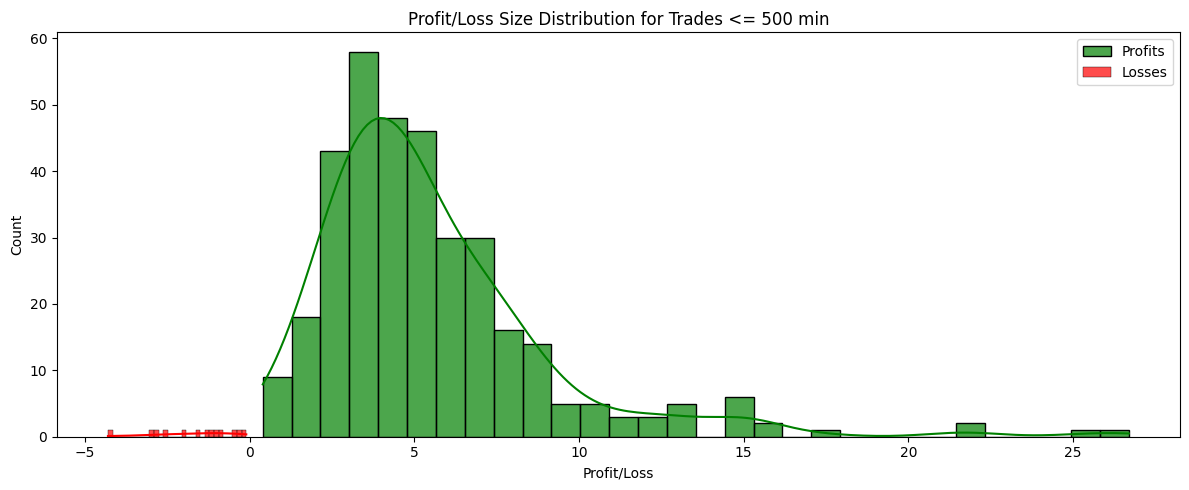

In [7]:
# 8. Profit/Loss Size Distribution (<=500min)

# Distribuzione della grandezza dei profitti e delle perdite per trade <= 500 minuti
plt.figure(figsize=(12, 5))
sns.histplot(plot_df_500[plot_df_500['Profit'] > 0]['Profit'], bins=30, color='green', label='Profits', alpha=0.7, kde=True)
sns.histplot(plot_df_500[plot_df_500['Profit'] <= 0]['Profit'], bins=30, color='red', label='Losses', alpha=0.7, kde=True)
plt.title('Profit/Loss Size Distribution for Trades <= 500 min')
plt.xlabel('Profit/Loss')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_20195/3772849723.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  profit_counts = plot_df.groupby('duration_bin')['Profit'].apply(lambda x: (x > 0).sum())
/tmp/ipykernel_20195/3772849723.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loss_counts = plot_df.groupby('duration_bin')['Profit'].apply(lambda x: (x <= 0).sum())


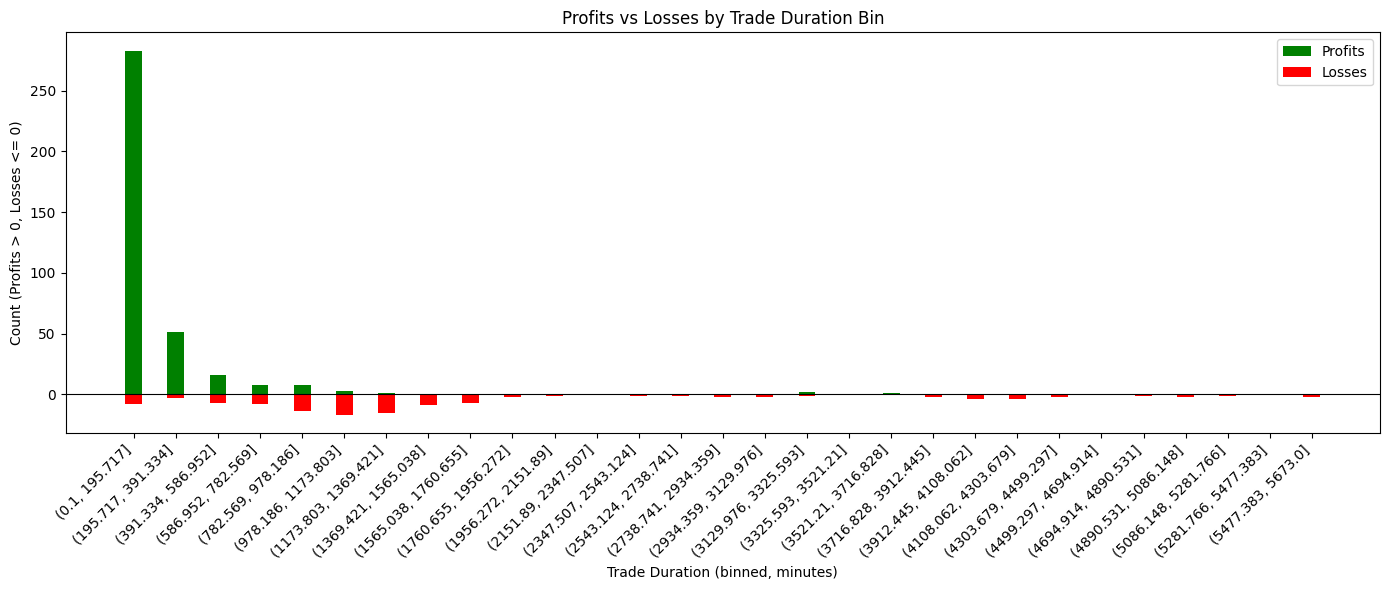

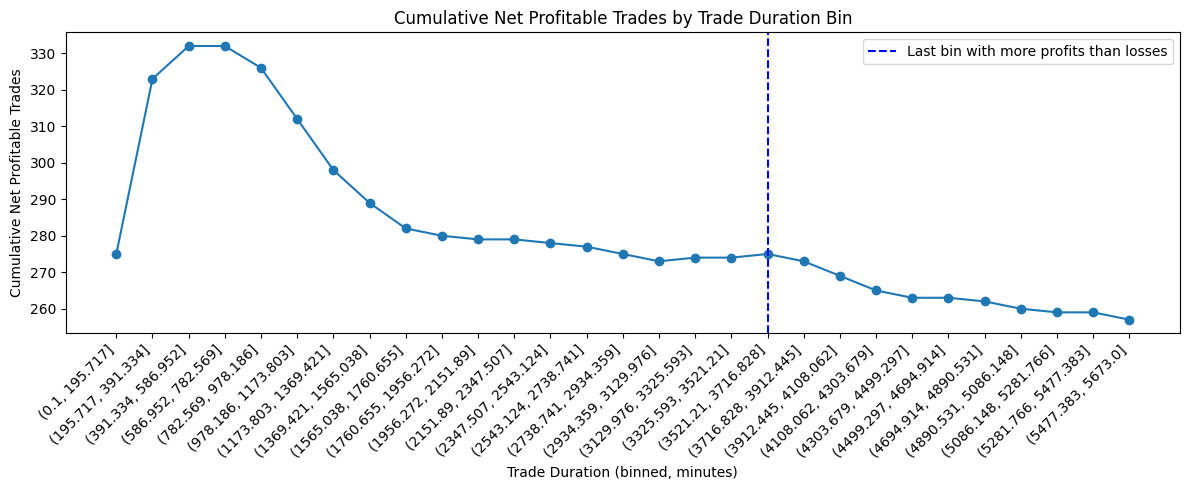

More profits than losses up to trade duration: 3716.8 minutes


In [8]:
# 6. Profits/Losses by Duration Bin

import numpy as np

# Bin trade durations
bins = np.linspace(plot_df['Trade_Duration'].min(), plot_df['Trade_Duration'].max(), 30)
plot_df['duration_bin'] = pd.cut(plot_df['Trade_Duration'], bins)

# Count profits and losses per bin
profit_counts = plot_df.groupby('duration_bin')['Profit'].apply(lambda x: (x > 0).sum())
loss_counts = plot_df.groupby('duration_bin')['Profit'].apply(lambda x: (x <= 0).sum())

# Calculate difference
diff_counts = profit_counts - loss_counts

# Find the last bin where profits > losses
last_profitable_bin = diff_counts[diff_counts > 0].index[-1] if (diff_counts > 0).any() else None

# Bar plot: Profits vs Losses by trade duration bin
plt.figure(figsize=(14, 6))
width = 0.4
plt.bar(profit_counts.index.astype(str), profit_counts.values, width=width, label='Profits', color='green', align='center')
plt.bar(loss_counts.index.astype(str), -loss_counts.values, width=width, label='Losses', color='red', align='center')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Trade Duration (binned, minutes)')
plt.ylabel('Count (Profits > 0, Losses <= 0)')
plt.title('Profits vs Losses by Trade Duration Bin')
plt.legend()
plt.tight_layout()
plt.show()

# Cumulative sum: net number of profitable trades as duration increases
cum_net = (profit_counts - loss_counts).cumsum()
plt.figure(figsize=(12, 5))
plt.plot(cum_net.index.astype(str), cum_net.values, marker='o')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Trade Duration (binned, minutes)')
plt.ylabel('Cumulative Net Profitable Trades')
plt.title('Cumulative Net Profitable Trades by Trade Duration Bin')
if last_profitable_bin is not None:
    plt.axvline(str(last_profitable_bin), color='blue', linestyle='--', label=f'Last bin with more profits than losses')
    plt.legend()
plt.tight_layout()
plt.show()

# Print the upper bound of the last profitable bin
if last_profitable_bin is not None:
    print(f"More profits than losses up to trade duration: {last_profitable_bin.right:.1f} minutes")
else:
    print('No duration bin with more profits than losses.')

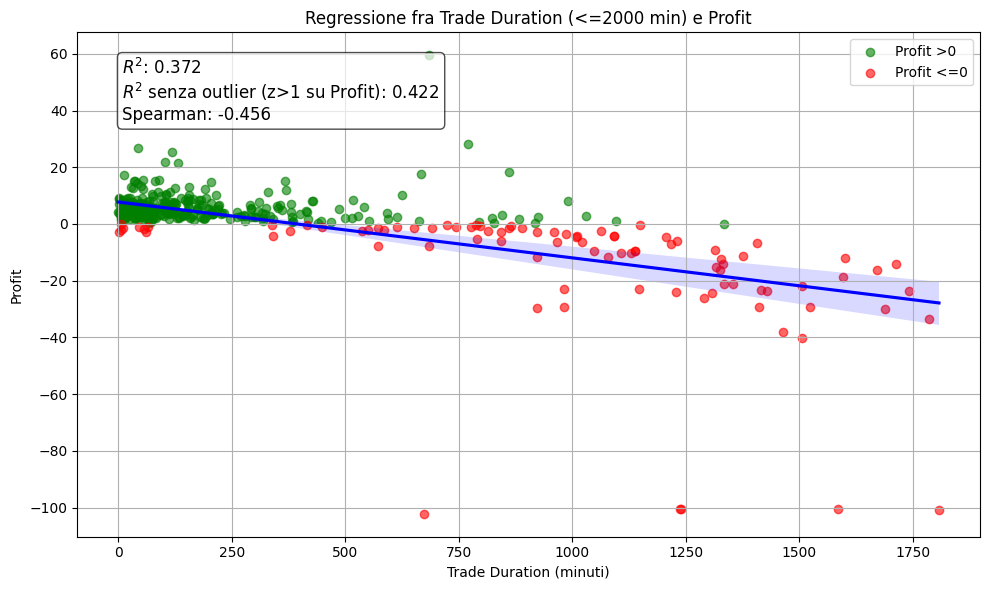

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, zscore

# Filtra solo le righe con valori validi e durata <= 2000 minuti
plot_df_short = df[(df['Trade_Duration'].notnull()) & (df['Profit'].notnull()) & (df['Trade_Duration'] <= 2000)].copy()

# Crea una colonna colore: verde se profit > 0, rosso se <= 0
plot_df_short['color'] = plot_df_short['Profit'].apply(lambda x: 'green' if x > 0 else 'red')

# Calcola R2 della regressione lineare
X = plot_df_short['Trade_Duration'].values.reshape(-1, 1)
y = plot_df_short['Profit'].values
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
r2 = r2_score(y, y_pred)

# Calcola coefficiente di correlazione di Spearman
spearman_corr, spearman_p = spearmanr(plot_df_short['Trade_Duration'], plot_df_short['Profit'])

# Calcola R2 senza outlier (usando z_threshold solo su Profit)
plot_df_short['z_profit'] = zscore(plot_df_short['Profit'])
no_outliers = plot_df_short[plot_df_short['z_profit'].abs() <= z_threshold]
X_no = no_outliers['Trade_Duration'].values.reshape(-1, 1)
y_no = no_outliers['Profit'].values
reg_no = LinearRegression().fit(X_no, y_no)
y_pred_no = reg_no.predict(X_no)
r2_no = r2_score(y_no, y_pred_no)

plt.figure(figsize=(10, 6))
# Scatter colorato manualmente
for color in ['green', 'red']:
    subset = plot_df_short[plot_df_short['color'] == color]
    plt.scatter(subset['Trade_Duration'], subset['Profit'], c=color, label=f'Profit {">0" if color=="green" else "<=0"}', alpha=0.6)
# Linea di regressione (senza colore dei punti)
sns.regplot(x='Trade_Duration', y='Profit', data=plot_df_short, scatter=False, line_kws={'color':'blue', 'label':'Regressione'})
plt.title('Regressione fra Trade Duration (<=2000 min) e Profit')
plt.xlabel('Trade Duration (minuti)')
plt.ylabel('Profit')
# Mostra R2 e Spearman sul grafico
plt.text(0.05, 0.95, f'$R^2$: {r2:.3f}\n$R^2$ senza outlier (z>{z_threshold} su Profit): {r2_no:.3f}\nSpearman: {spearman_corr:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 9. Hourly Profit Analysis

This section analyzes trading performance across different hours of the day to identify optimal and sub-optimal trading periods. We'll examine:

- **Profit distribution by hour of day**
- **Win rate by hour**
- **Average profit/loss by hour**
- **Heatmap visualization of hourly performance**
- **Cumulative returns by hour patterns**

The analysis will help identify if there are specific time periods when the trading strategy performs significantly better or worse.

In [10]:
# 9.1 Hourly Data Preparation

# Extract hour from the Time column for completed trades
hourly_df = plot_df.copy()
hourly_df['Hour'] = hourly_df.index.map(lambda x: df.loc[x, 'Time'].hour)

# Create profit/loss indicators
hourly_df['Is_Profit'] = hourly_df['Profit'] > 0
hourly_df['Is_Loss'] = hourly_df['Profit'] <= 0

# Basic hourly statistics
print("=== HOURLY TRADING STATISTICS ===")
print(f"Total trades analyzed: {len(hourly_df)}")
print(f"Hours with trading activity: {sorted(hourly_df['Hour'].unique())}")
print(f"Most active hour: {hourly_df['Hour'].value_counts().index[0]} ({hourly_df['Hour'].value_counts().iloc[0]} trades)")
print(f"Least active hour: {hourly_df['Hour'].value_counts().index[-1]} ({hourly_df['Hour'].value_counts().iloc[-1]} trades)")

hourly_df.head()

=== HOURLY TRADING STATISTICS ===
Total trades analyzed: 490
Hours with trading activity: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23)]
Most active hour: 10 (49 trades)
Least active hour: 5 (3 trades)


,Time,Deal,Symbol,Type,Direction,Volume,Price,Order,Commission,Swap,Profit,Balance,Comment,Trade_Duration,color,z_profit,duration_bin,Hour,Is_Profit,Is_Loss
1,2024-11-01 11:11:40,3,EURGBP.sml,buy,out,0.1,0.84199,3.0,0,0,17.8,10017.8,tp 0.84199,666.7,green,1.088040,"(586.952, 782.569]",11,True,False
3,2024-11-04 09:49:39,5,EURGBP.sml,sell,out,0.1,0.83940,5.0,0,0,-16.0,10001.8,tp 0.83940,4000.7,red,-0.970908,"(3912.445, 4108.062]",9,False,True
5,2024-11-04 17:11:00,7,EURGBP.sml,buy,out,0.1,0.83925,7.0,0,0,12.1,10013.9,NaN,370.0,green,0.740821,"(195.717, 391.334]",17,True,False
7,2024-11-04 21:51:00,9,EURGBP.sml,buy,out,0.1,0.83972,9.0,0,0,6.6,10020.5,NaN,222.0,green,0.405785,"(195.717, 391.334]",21,True,False
9,2024-11-05 20:38:05,11,EURGBP.sml,sell,out,0.1,0.83926,11.0,0,0,-0.6,10019.9,tp 0.83926,797.1,red,-0.032807,"(782.569, 978.186]",20,False,True


In [11]:
# 9.2 Hourly Aggregation and Metrics

# Aggregate by hour
hourly_stats = hourly_df.groupby('Hour').agg({
    'Profit': ['count', 'sum', 'mean', 'std', 'min', 'max'],
    'Is_Profit': ['sum', 'mean'],
    'Trade_Duration': ['mean', 'median']
}).round(4)

# Flatten column names
hourly_stats.columns = ['_'.join(col).strip() for col in hourly_stats.columns.values]
hourly_stats.columns = ['Total_Trades', 'Total_Profit', 'Avg_Profit', 'Std_Profit', 'Min_Profit', 'Max_Profit',
                       'Winning_Trades', 'Win_Rate', 'Avg_Duration', 'Median_Duration']

# Add risk-adjusted metrics
hourly_stats['Profit_Per_Trade'] = hourly_stats['Total_Profit'] / hourly_stats['Total_Trades']
hourly_stats['Sharpe_Ratio'] = hourly_stats['Avg_Profit'] / hourly_stats['Std_Profit']
hourly_stats['Risk_Reward'] = hourly_stats['Avg_Profit'] / hourly_stats['Std_Profit'].abs()

# Sort by total profit
hourly_stats_sorted = hourly_stats.sort_values('Total_Profit', ascending=False)

print("=== TOP 5 MOST PROFITABLE HOURS ===")
print(hourly_stats_sorted[['Total_Profit', 'Win_Rate', 'Avg_Profit', 'Total_Trades']].head())

print("\n=== TOP 5 LEAST PROFITABLE HOURS ===")
print(hourly_stats_sorted[['Total_Profit', 'Win_Rate', 'Avg_Profit', 'Total_Trades']].tail())

hourly_stats.head()

=== TOP 5 MOST PROFITABLE HOURS ===
      Total_Profit  Win_Rate  Avg_Profit  Total_Trades
Hour                                                  
17           211.2    0.9524      5.0286            42
14           189.1    0.9643      6.7536            28
22           128.5    0.9412      7.5588            17
13           126.1    0.9333      4.2033            30
18           114.3    0.8889      4.2333            27

=== TOP 5 LEAST PROFITABLE HOURS ===
      Total_Profit  Win_Rate  Avg_Profit  Total_Trades
Hour                                                  
12          -139.0    0.8000     -6.9500            20
16          -147.6    0.7750     -3.6900            40
9           -155.8    0.5758     -4.7212            33
8           -193.1    0.3750    -12.0688            16
10          -208.4    0.5918     -4.2531            49


,Total_Trades,Total_Profit,Avg_Profit,Std_Profit,Min_Profit,Max_Profit,Winning_Trades,Win_Rate,Avg_Duration,Median_Duration,Profit_Per_Trade,Sharpe_Ratio,Risk_Reward
Hour,,,,,,,,,,,,,
0,16,-12.0,-0.7500,3.2733,-5.1,6.4,4,0.2500,885.4812,123.30,-0.750000,-0.229127,-0.229127
1,12,21.9,1.8250,5.1079,-11.8,9.0,10,0.8333,462.7417,61.45,1.825000,0.357290,0.357290
2,6,33.6,5.6000,4.2138,1.5,12.2,6,1.0000,767.9833,179.00,5.600000,1.328967,1.328967
3,7,-76.9,-10.9857,43.1298,-102.2,18.2,5,0.7143,1024.8286,262.00,-10.985714,-0.254713,-0.254713
4,13,4.8,0.3692,6.5236,-16.4,8.8,8,0.6154,733.3692,552.90,0.369231,0.056595,0.056595


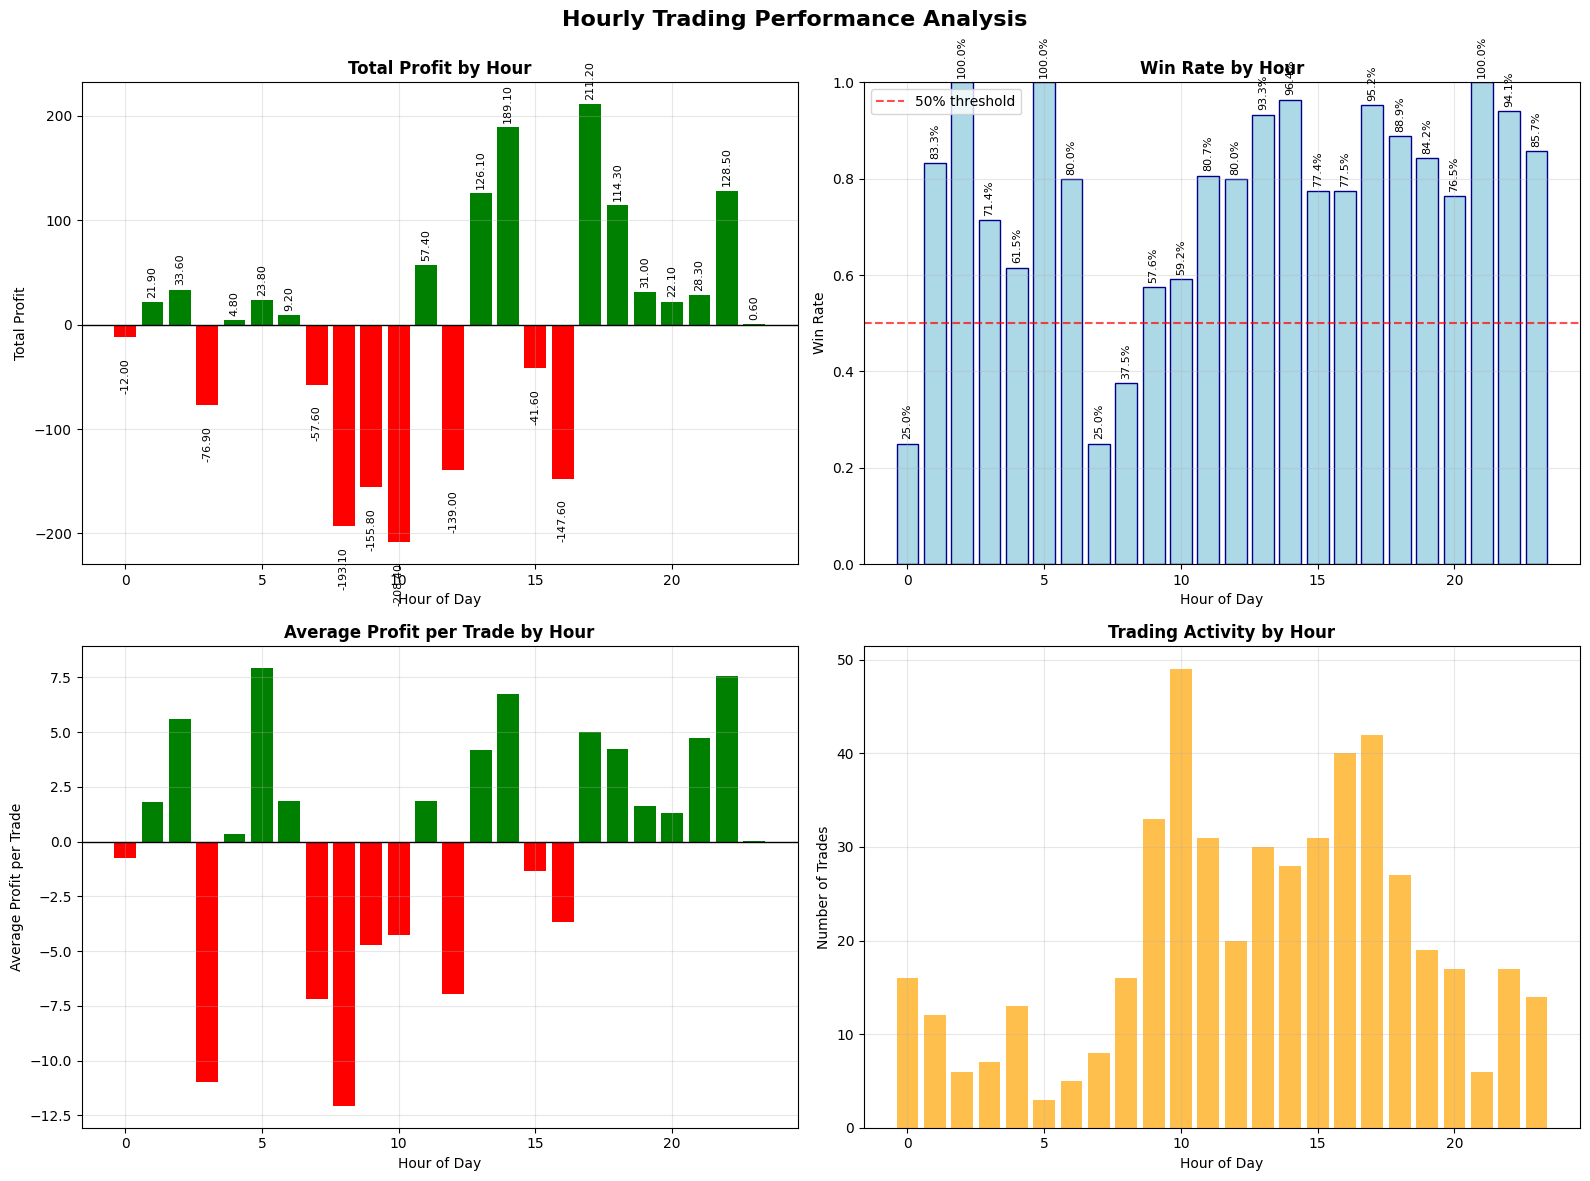

In [12]:
# 9.3 Hourly Profit Visualizations

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hourly Trading Performance Analysis', fontsize=16, fontweight='bold')

# 1. Total Profit by Hour
ax1 = axes[0, 0]
bars = ax1.bar(hourly_stats.index, hourly_stats['Total_Profit'], 
               color=['green' if x > 0 else 'red' for x in hourly_stats['Total_Profit']])
ax1.set_title('Total Profit by Hour', fontweight='bold')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Total Profit')
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linewidth=1)
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3 if height >= 0 else -15),
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top',
                fontsize=8, rotation=90)

# 2. Win Rate by Hour
ax2 = axes[0, 1]
bars2 = ax2.bar(hourly_stats.index, hourly_stats['Win_Rate'], 
                color='lightblue', edgecolor='darkblue')
ax2.set_title('Win Rate by Hour', fontweight='bold')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Win Rate')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)
ax2.axhline(0.5, color='red', linestyle='--', alpha=0.7, label='50% threshold')
ax2.legend()
# Add percentage labels
for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.1%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=8, rotation=90)

# 3. Average Profit per Trade by Hour
ax3 = axes[1, 0]
bars3 = ax3.bar(hourly_stats.index, hourly_stats['Avg_Profit'], 
                color=['green' if x > 0 else 'red' for x in hourly_stats['Avg_Profit']])
ax3.set_title('Average Profit per Trade by Hour', fontweight='bold')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Average Profit per Trade')
ax3.grid(True, alpha=0.3)
ax3.axhline(0, color='black', linewidth=1)

# 4. Number of Trades by Hour
ax4 = axes[1, 1]
bars4 = ax4.bar(hourly_stats.index, hourly_stats['Total_Trades'], 
                color='orange', alpha=0.7)
ax4.set_title('Trading Activity by Hour', fontweight='bold')
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Number of Trades')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

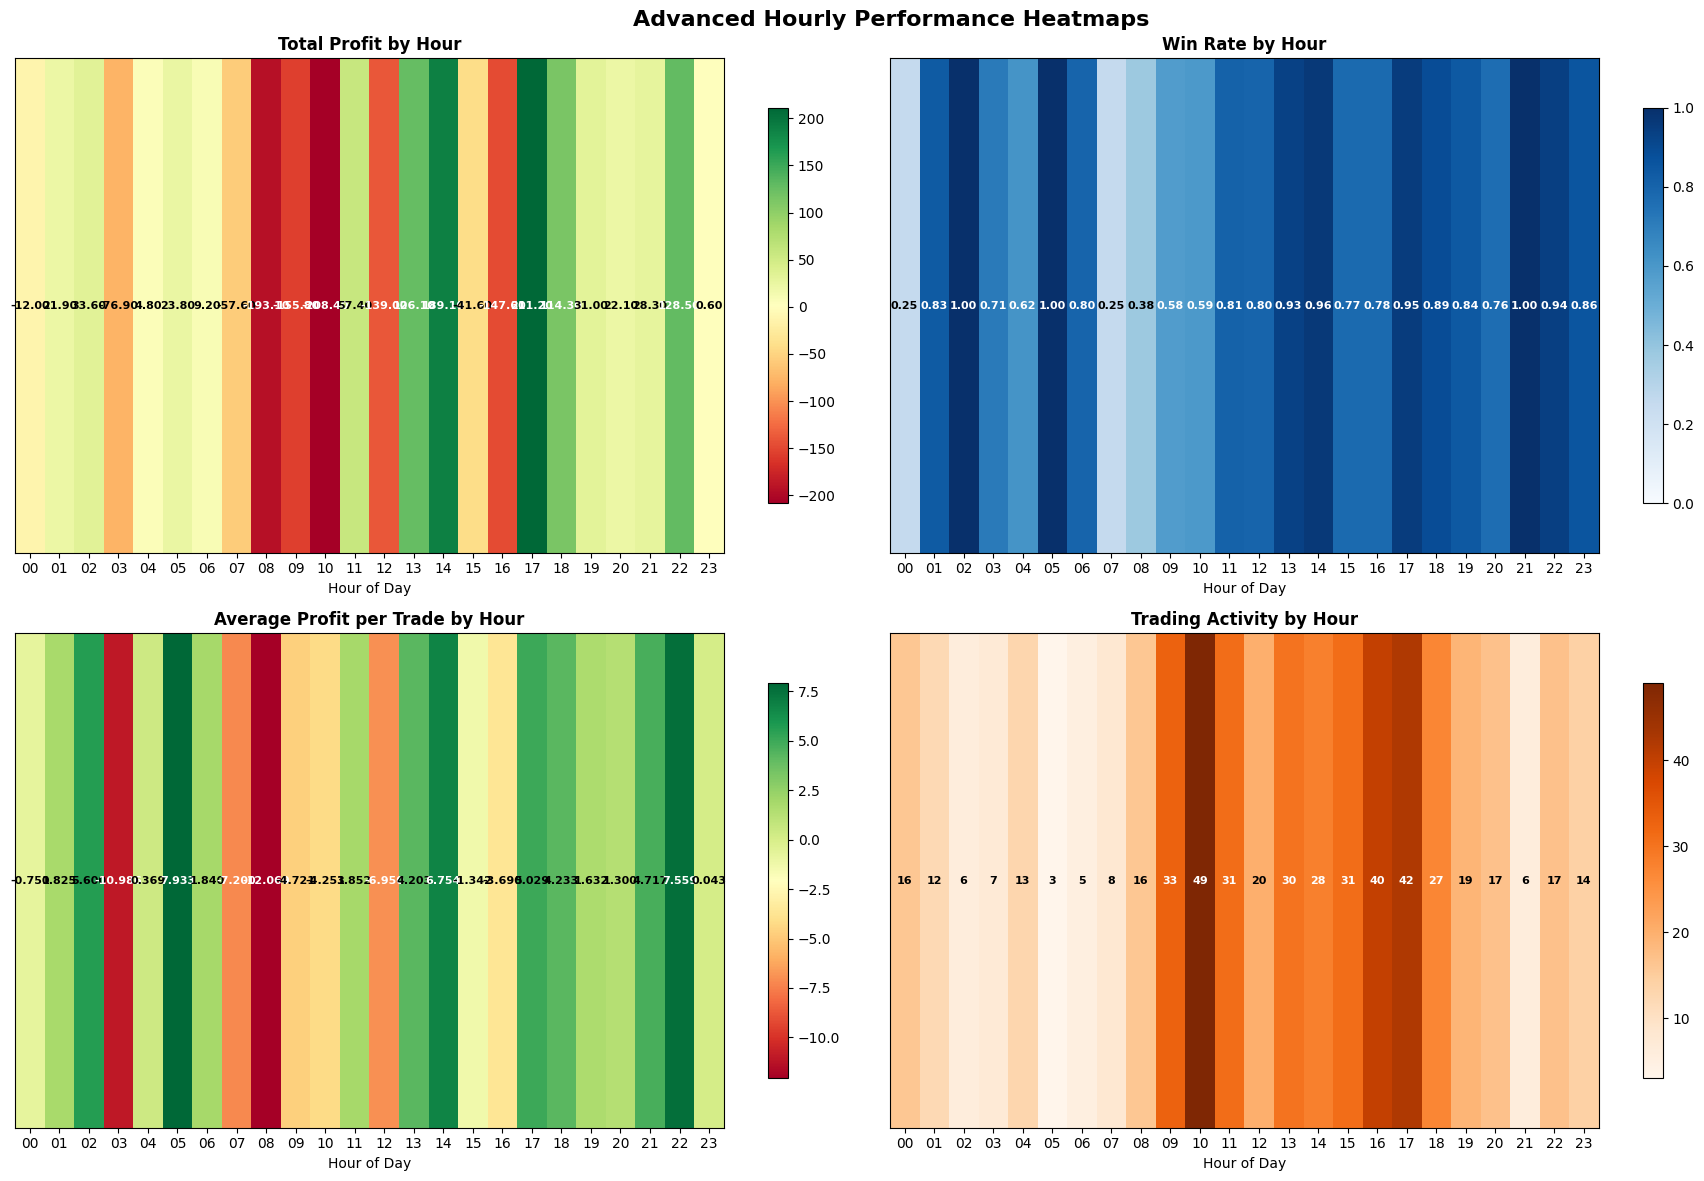

In [13]:
# 9.4 Advanced Heatmap Visualization

# Create a comprehensive heatmap showing multiple metrics by hour
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Advanced Hourly Performance Heatmaps', fontsize=16, fontweight='bold')

# Prepare data for heatmaps (reshape for single row heatmaps)
hours_range = range(24)
metrics_data = {}

for hour in hours_range:
    if hour in hourly_stats.index:
        metrics_data[hour] = hourly_stats.loc[hour]
    else:
        # Fill missing hours with zeros/NaN
        metrics_data[hour] = {
            'Total_Profit': 0,
            'Win_Rate': 0,
            'Avg_Profit': 0,
            'Total_Trades': 0
        }

# Convert to arrays for heatmap
total_profits = np.array([[metrics_data[h]['Total_Profit'] if h in hourly_stats.index else 0 for h in hours_range]])
win_rates = np.array([[metrics_data[h]['Win_Rate'] if h in hourly_stats.index else 0 for h in hours_range]])
avg_profits = np.array([[metrics_data[h]['Avg_Profit'] if h in hourly_stats.index else 0 for h in hours_range]])
trade_counts = np.array([[metrics_data[h]['Total_Trades'] if h in hourly_stats.index else 0 for h in hours_range]])

# 1. Total Profit Heatmap
ax1 = axes[0, 0]
im1 = ax1.imshow(total_profits, cmap='RdYlGn', aspect='auto')
ax1.set_title('Total Profit by Hour', fontweight='bold')
ax1.set_xlabel('Hour of Day')
ax1.set_xticks(range(24))
ax1.set_xticklabels([f'{h:02d}' for h in hours_range])
ax1.set_yticks([])
# Add text annotations
for i, hour in enumerate(hours_range):
    value = total_profits[0, i]
    ax1.text(i, 0, f'{value:.2f}', ha='center', va='center', 
             color='white' if abs(value) > np.max(np.abs(total_profits))*0.5 else 'black',
             fontweight='bold', fontsize=8)
plt.colorbar(im1, ax=ax1, shrink=0.8)

# 2. Win Rate Heatmap
ax2 = axes[0, 1]
im2 = ax2.imshow(win_rates, cmap='Blues', aspect='auto', vmin=0, vmax=1)
ax2.set_title('Win Rate by Hour', fontweight='bold')
ax2.set_xlabel('Hour of Day')
ax2.set_xticks(range(24))
ax2.set_xticklabels([f'{h:02d}' for h in hours_range])
ax2.set_yticks([])
# Add text annotations
for i, hour in enumerate(hours_range):
    value = win_rates[0, i]
    ax2.text(i, 0, f'{value:.2f}', ha='center', va='center', 
             color='white' if value > 0.5 else 'black',
             fontweight='bold', fontsize=8)
plt.colorbar(im2, ax=ax2, shrink=0.8)

# 3. Average Profit per Trade Heatmap
ax3 = axes[1, 0]
im3 = ax3.imshow(avg_profits, cmap='RdYlGn', aspect='auto')
ax3.set_title('Average Profit per Trade by Hour', fontweight='bold')
ax3.set_xlabel('Hour of Day')
ax3.set_xticks(range(24))
ax3.set_xticklabels([f'{h:02d}' for h in hours_range])
ax3.set_yticks([])
# Add text annotations
for i, hour in enumerate(hours_range):
    value = avg_profits[0, i]
    ax3.text(i, 0, f'{value:.3f}', ha='center', va='center', 
             color='white' if abs(value) > np.max(np.abs(avg_profits))*0.5 else 'black',
             fontweight='bold', fontsize=8)
plt.colorbar(im3, ax=ax3, shrink=0.8)

# 4. Trading Activity Heatmap
ax4 = axes[1, 1]
im4 = ax4.imshow(trade_counts, cmap='Oranges', aspect='auto')
ax4.set_title('Trading Activity by Hour', fontweight='bold')
ax4.set_xlabel('Hour of Day')
ax4.set_xticks(range(24))
ax4.set_xticklabels([f'{h:02d}' for h in hours_range])
ax4.set_yticks([])
# Add text annotations
for i, hour in enumerate(hours_range):
    value = trade_counts[0, i]
    ax4.text(i, 0, f'{int(value)}', ha='center', va='center', 
             color='white' if value > np.max(trade_counts)*0.5 else 'black',
             fontweight='bold', fontsize=8)
plt.colorbar(im4, ax=ax4, shrink=0.8)

plt.tight_layout()
plt.show()

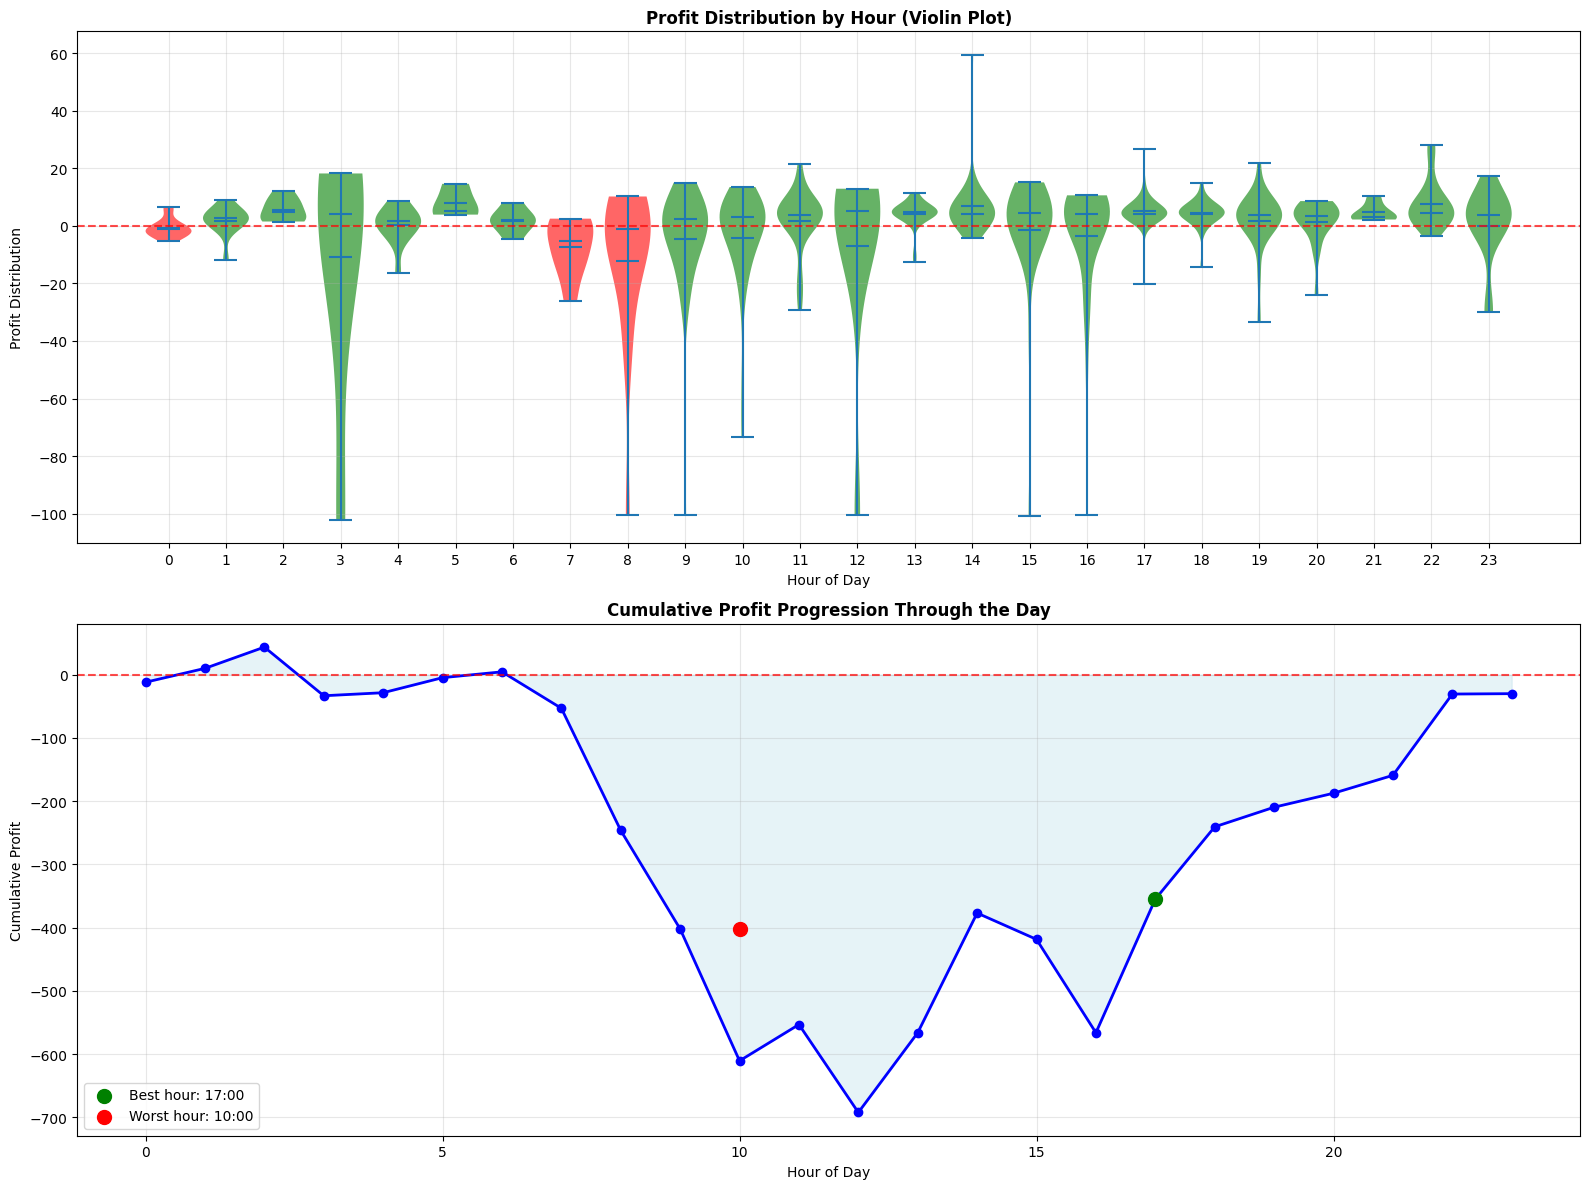

In [14]:
# 9.5 Detailed Hourly Distribution Analysis

# Create advanced distribution plots
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 1. Violin Plot: Profit distribution by hour
ax1 = axes[0]
# Filter out hours with too few trades for meaningful violin plots
hours_with_enough_data = hourly_df['Hour'].value_counts()
hours_to_plot = hours_with_enough_data[hours_with_enough_data >= 3].index.tolist()
filtered_hourly_df = hourly_df[hourly_df['Hour'].isin(hours_to_plot)]

if len(hours_to_plot) > 0:
    violin_parts = ax1.violinplot([filtered_hourly_df[filtered_hourly_df['Hour'] == h]['Profit'].values 
                                  for h in sorted(hours_to_plot)], 
                                 positions=sorted(hours_to_plot), widths=0.8, showmeans=True, showmedians=True)
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Profit Distribution')
    ax1.set_title('Profit Distribution by Hour (Violin Plot)', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='red', linestyle='--', alpha=0.7)
    ax1.set_xticks(sorted(hours_to_plot))
    
    # Color violin plots based on median profit
    for i, hour in enumerate(sorted(hours_to_plot)):
        median_profit = filtered_hourly_df[filtered_hourly_df['Hour'] == hour]['Profit'].median()
        color = 'green' if median_profit > 0 else 'red'
        violin_parts['bodies'][i].set_facecolor(color)
        violin_parts['bodies'][i].set_alpha(0.6)
else:
    ax1.text(0.5, 0.5, 'Insufficient data for violin plot', transform=ax1.transAxes, 
             ha='center', va='center', fontsize=14)
    ax1.set_title('Profit Distribution by Hour (Insufficient Data)', fontweight='bold')

# 2. Cumulative Profit by Hour Through the Day
ax2 = axes[1]
# Calculate cumulative profit progression through the day
cumulative_by_hour = hourly_stats['Total_Profit'].cumsum()
line = ax2.plot(cumulative_by_hour.index, cumulative_by_hour.values, 
                marker='o', linewidth=2, markersize=6, color='blue')
ax2.fill_between(cumulative_by_hour.index, cumulative_by_hour.values, 0, 
                 alpha=0.3, color='lightblue')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Cumulative Profit')
ax2.set_title('Cumulative Profit Progression Through the Day', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='red', linestyle='--', alpha=0.7)

# Highlight best and worst performing hours
max_profit_hour = hourly_stats['Total_Profit'].idxmax()
min_profit_hour = hourly_stats['Total_Profit'].idxmin()
ax2.scatter(max_profit_hour, cumulative_by_hour[max_profit_hour], 
           color='green', s=100, zorder=5, label=f'Best hour: {max_profit_hour}:00')
ax2.scatter(min_profit_hour, cumulative_by_hour[min_profit_hour] - hourly_stats.loc[min_profit_hour, 'Total_Profit'], 
           color='red', s=100, zorder=5, label=f'Worst hour: {min_profit_hour}:00')
ax2.legend()

plt.tight_layout()
plt.show()

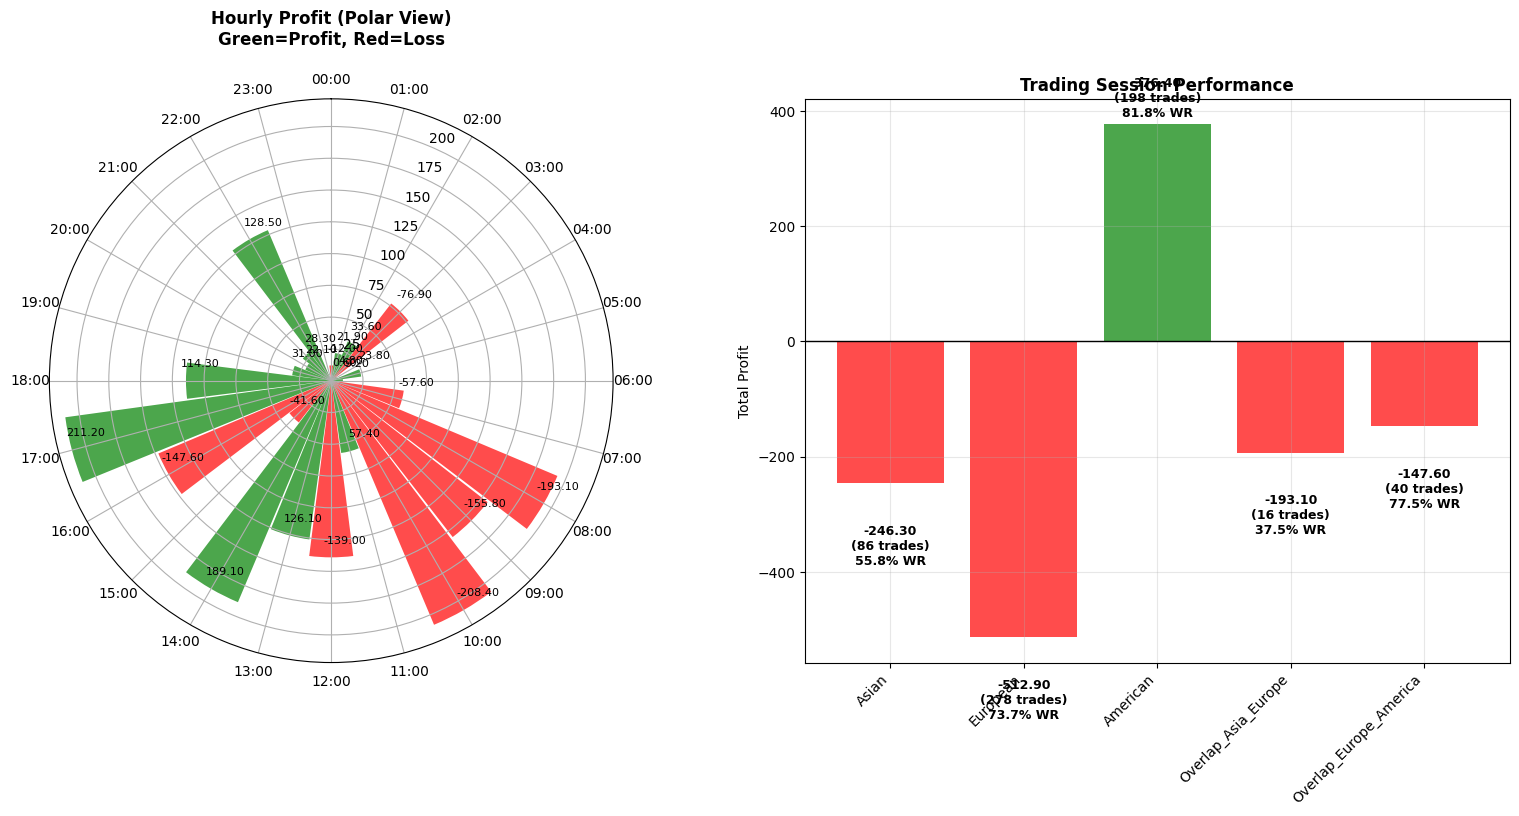


=== TRADING SESSION SUMMARY ===
Asian:
  Total Profit: -246.3000
  Total Trades: 86
  Win Rate: 55.81%
  Avg Profit per Trade: -2.8640

European:
  Total Profit: -512.9000
  Total Trades: 278
  Win Rate: 73.74%
  Avg Profit per Trade: -1.8450

American:
  Total Profit: 376.4000
  Total Trades: 198
  Win Rate: 81.82%
  Avg Profit per Trade: 1.9010

Overlap_Asia_Europe:
  Total Profit: -193.1000
  Total Trades: 16
  Win Rate: 37.50%
  Avg Profit per Trade: -12.0687

Overlap_Europe_America:
  Total Profit: -147.6000
  Total Trades: 40
  Win Rate: 77.50%
  Avg Profit per Trade: -3.6900



In [15]:
# 9.6 Polar Chart and Trading Session Analysis

# Create polar visualization
fig = plt.figure(figsize=(16, 8))

# 1. Polar chart showing profit by hour (like a clock)
ax1 = plt.subplot(121, projection='polar')
theta = np.linspace(0, 2 * np.pi, 24, endpoint=False)
radii = []
colors = []

for hour in range(24):
    if hour in hourly_stats.index:
        profit = hourly_stats.loc[hour, 'Total_Profit']
        radii.append(abs(profit))
        colors.append('green' if profit > 0 else 'red')
    else:
        radii.append(0)
        colors.append('gray')

bars = ax1.bar(theta, radii, width=0.25, bottom=0, color=colors, alpha=0.7)
ax1.set_theta_zero_location('N')  # 0 hours at top
ax1.set_theta_direction(-1)  # Clockwise
ax1.set_title('Hourly Profit (Polar View)\nGreen=Profit, Red=Loss', 
              fontweight='bold', pad=20)
ax1.set_thetagrids(range(0, 360, 15), [f'{h:02d}:00' for h in range(24)])

# Add value labels
for bar, hour in zip(bars, range(24)):
    if hour in hourly_stats.index:
        profit = hourly_stats.loc[hour, 'Total_Profit']
        if abs(profit) > 0:
            ax1.annotate(f'{profit:.2f}', 
                        xy=(theta[hour], abs(profit)), 
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=8, ha='center')

# 2. Trading Session Performance Analysis
ax2 = plt.subplot(122)

# Define trading sessions (approximate)
sessions = {
    'Asian': list(range(0, 9)),      # 00:00 - 08:59
    'European': list(range(8, 17)),   # 08:00 - 16:59  
    'American': list(range(16, 24)) + list(range(0, 1)),  # 16:00 - 00:59
    'Overlap_Asia_Europe': list(range(8, 9)),    # 08:00 - 08:59
    'Overlap_Europe_America': list(range(16, 17)) # 16:00 - 16:59
}

session_stats = {}
for session_name, hours in sessions.items():
    session_trades = hourly_df[hourly_df['Hour'].isin(hours)]
    if len(session_trades) > 0:
        session_stats[session_name] = {
            'Total_Profit': session_trades['Profit'].sum(),
            'Total_Trades': len(session_trades),
            'Win_Rate': session_trades['Is_Profit'].mean(),
            'Avg_Profit': session_trades['Profit'].mean()
        }
    else:
        session_stats[session_name] = {
            'Total_Profit': 0,
            'Total_Trades': 0,
            'Win_Rate': 0,
            'Avg_Profit': 0
        }

# Plot session performance
session_names = list(session_stats.keys())
session_profits = [session_stats[s]['Total_Profit'] for s in session_names]
session_colors = ['green' if p > 0 else 'red' for p in session_profits]

bars = ax2.bar(session_names, session_profits, color=session_colors, alpha=0.7)
ax2.set_title('Trading Session Performance', fontweight='bold')
ax2.set_ylabel('Total Profit')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linewidth=1)

# Rotate x-axis labels for better readability
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar, session in zip(bars, session_names):
    height = bar.get_height()
    trades = session_stats[session]['Total_Trades']
    win_rate = session_stats[session]['Win_Rate']
    ax2.annotate(f'{height:.2f}\n({trades} trades)\n{win_rate:.1%} WR',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3 if height >= 0 else -30),
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top',
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print session summary
print("\n=== TRADING SESSION SUMMARY ===")
for session, stats in session_stats.items():
    print(f"{session}:")
    print(f"  Total Profit: {stats['Total_Profit']:.4f}")
    print(f"  Total Trades: {stats['Total_Trades']}")
    print(f"  Win Rate: {stats['Win_Rate']:.2%}")
    print(f"  Avg Profit per Trade: {stats['Avg_Profit']:.4f}")
    print()

In [16]:
# 9.7 Statistical Significance and Risk Analysis

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Statistical tests to determine if hourly differences are significant
print("=== STATISTICAL SIGNIFICANCE TESTING ===")

# Group hours into profitable vs unprofitable
profitable_hours = hourly_stats[hourly_stats['Total_Profit'] > 0].index.tolist()
unprofitable_hours = hourly_stats[hourly_stats['Total_Profit'] <= 0].index.tolist()

print(f"Profitable hours: {profitable_hours}")
print(f"Unprofitable hours: {unprofitable_hours}")

if len(profitable_hours) > 0 and len(unprofitable_hours) > 0:
    # Get individual trade data for profitable vs unprofitable hours
    profitable_trades = hourly_df[hourly_df['Hour'].isin(profitable_hours)]['Profit']
    unprofitable_trades = hourly_df[hourly_df['Hour'].isin(unprofitable_hours)]['Profit']
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(profitable_trades, unprofitable_trades)
    print(f"\nT-test between profitable and unprofitable hours:")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Statistically significant (p < 0.05): {'Yes' if p_value < 0.05 else 'No'}")

# Risk analysis by hour
print(f"\n=== RISK ANALYSIS BY HOUR ===")
hourly_risk = hourly_df.groupby('Hour')['Profit'].agg(['std', 'min', 'max']).round(4)
hourly_risk['Risk_Range'] = hourly_risk['max'] - hourly_risk['min']
hourly_risk['Downside_Risk'] = hourly_risk[hourly_risk['min'] < 0]['min'].abs()
hourly_risk['Downside_Risk'] = hourly_risk['Downside_Risk'].fillna(0)

risk_sorted = hourly_risk.sort_values('std', ascending=False)
print("Top 5 most volatile hours (highest risk):")
print(risk_sorted[['std', 'Risk_Range', 'Downside_Risk']].head())

print(f"\n=== OPTIMAL TRADING HOURS RECOMMENDATION ===")
# Calculate risk-adjusted returns
optimal_criteria = hourly_stats.copy()
optimal_criteria['Risk_Adjusted_Return'] = optimal_criteria['Avg_Profit'] / (optimal_criteria['Std_Profit'] + 0.0001)  # Add small value to avoid division by zero
optimal_criteria['Profit_Factor'] = optimal_criteria['Total_Profit'] / optimal_criteria['Total_Trades']

# Filter hours with minimum trade count for reliability
min_trades_threshold = 5
reliable_hours = optimal_criteria[optimal_criteria['Total_Trades'] >= min_trades_threshold]

if len(reliable_hours) > 0:
    # Best hours based on different criteria
    best_total_profit = reliable_hours.loc[reliable_hours['Total_Profit'].idxmax()]
    best_win_rate = reliable_hours.loc[reliable_hours['Win_Rate'].idxmax()]
    best_avg_profit = reliable_hours.loc[reliable_hours['Avg_Profit'].idxmax()]
    best_risk_adjusted = reliable_hours.loc[reliable_hours['Risk_Adjusted_Return'].idxmax()]
    
    print(f"Best hour for total profit: {best_total_profit.name}:00 (Profit: {best_total_profit['Total_Profit']:.4f})")
    print(f"Best hour for win rate: {best_win_rate.name}:00 (Win Rate: {best_win_rate['Win_Rate']:.2%})")
    print(f"Best hour for avg profit: {best_avg_profit.name}:00 (Avg: {best_avg_profit['Avg_Profit']:.4f})")
    print(f"Best hour for risk-adjusted return: {best_risk_adjusted.name}:00 (Ratio: {best_risk_adjusted['Risk_Adjusted_Return']:.4f})")
    
    # Worst hours
    worst_total_profit = reliable_hours.loc[reliable_hours['Total_Profit'].idxmin()]
    worst_win_rate = reliable_hours.loc[reliable_hours['Win_Rate'].idxmin()]
    
    print(f"\nWorst hour for total profit: {worst_total_profit.name}:00 (Loss: {worst_total_profit['Total_Profit']:.4f})")
    print(f"Worst hour for win rate: {worst_win_rate.name}:00 (Win Rate: {worst_win_rate['Win_Rate']:.2%})")
else:
    print("Insufficient data for reliable recommendations (minimum 5 trades per hour required)")

# Final comprehensive summary
print(f"\n=== COMPREHENSIVE HOURLY SUMMARY ===")
total_profit = hourly_df['Profit'].sum()
total_trades = len(hourly_df)
overall_win_rate = hourly_df['Is_Profit'].mean()

print(f"Overall Performance:")
print(f"  Total Profit: {total_profit:.4f}")
print(f"  Total Trades: {total_trades}")
print(f"  Overall Win Rate: {overall_win_rate:.2%}")
print(f"  Hours Analyzed: {len(hourly_stats)}")
print(f"  Most Active Hour: {hourly_stats['Total_Trades'].idxmax()}:00 ({hourly_stats['Total_Trades'].max()} trades)")
print(f"  Most Profitable Hour: {hourly_stats['Total_Profit'].idxmax()}:00 ({hourly_stats['Total_Profit'].max():.4f} profit)")
print(f"  Least Profitable Hour: {hourly_stats['Total_Profit'].idxmin()}:00 ({hourly_stats['Total_Profit'].min():.4f} profit)")

=== STATISTICAL SIGNIFICANCE TESTING ===
Profitable hours: [1, 2, 4, 5, 6, 11, 13, 14, 17, 18, 19, 20, 21, 22, 23]
Unprofitable hours: [0, 3, 7, 8, 9, 10, 12, 15, 16]

T-test between profitable and unprofitable hours:
T-statistic: 5.8150
P-value: 0.0000
Statistically significant (p < 0.05): Yes

=== RISK ANALYSIS BY HOUR ===
Top 5 most volatile hours (highest risk):
          std  Risk_Range  Downside_Risk
Hour                                    
3     43.1298       120.4          102.2
12    33.1295       113.5          100.6
8     27.8140       110.8          100.6
16    21.4361       111.2          100.6
15    20.6984       115.8          100.7

=== OPTIMAL TRADING HOURS RECOMMENDATION ===
Best hour for total profit: 17:00 (Profit: 211.2000)
Best hour for win rate: 2:00 (Win Rate: 100.00%)
Best hour for avg profit: 22:00 (Avg: 7.5588)
Best hour for risk-adjusted return: 21:00 (Ratio: 1.4543)

Worst hour for total profit: 10:00 (Loss: -208.4000)
Worst hour for win rate: 0:00 (Win Rat

## 10. American Session Backtest & Equity Curve

Based on the hourly analysis, the American session (16:00-23:59) showed the best performance with +376.4 profit and 81.8% win rate. 

This section creates a backtest that **only allows trades to open during the American session** and plots the resulting equity curve. We'll be careful to avoid repainting by ensuring trades can only start during the specified hours.

### Backtest Rules:
- **Entry allowed only during**: 16:00 - 23:59 (American session)
- **Exit**: Natural trade exit (regardless of time)
- **Consistency**: No look-ahead bias or repainting
- **Equity tracking**: Cumulative P&L over time

In [17]:
# 10.1 American Session Trade Filtering

# Define American session hours (16:00 - 23:59)
AMERICAN_SESSION_START = 16
AMERICAN_SESSION_END = 23

print("=== AMERICAN SESSION BACKTEST SETUP ===")
print(f"Session hours: {AMERICAN_SESSION_START}:00 - {AMERICAN_SESSION_END}:59")

# Create a copy of the original dataframe for backtest
backtest_df = df.copy()

# Add hour information to all trades
backtest_df['Hour'] = backtest_df['Time'].dt.hour

# Identify trade pairs (entry and exit)
american_trades = []
current_entry = None

print("\n=== FILTERING TRADES FOR AMERICAN SESSION ===")
total_original_trades = 0
american_session_trades = 0

for i in range(len(backtest_df)):
    row = backtest_df.iloc[i]
    
    if row['Direction'] == 'in':
        total_original_trades += 1
        # Check if entry is during American session
        if AMERICAN_SESSION_START <= row['Hour'] <= AMERICAN_SESSION_END:
            current_entry = {
                'entry_index': i,
                'entry_time': row['Time'],
                'entry_hour': row['Hour']
            }
    
    elif row['Direction'] == 'out' and current_entry is not None:
        # Found exit for a valid American session entry
        exit_info = {
            'exit_index': i,
            'exit_time': row['Time'],
            'exit_hour': row['Hour'],
            'profit': row['Profit']
        }
        
        # Combine entry and exit information
        trade_info = {**current_entry, **exit_info}
        american_trades.append(trade_info)
        american_session_trades += 1
        
        # Reset for next trade
        current_entry = None
    
    elif row['Direction'] == 'out':
        # Exit without valid American session entry - reset
        current_entry = None

print(f"Total original trades: {total_original_trades}")
print(f"American session trades: {american_session_trades}")
print(f"Filtering ratio: {american_session_trades/total_original_trades:.2%}")

# Convert to DataFrame for easier analysis
american_trades_df = pd.DataFrame(american_trades)
if len(american_trades_df) > 0:
    print(f"\nFirst 5 American session trades:")
    print(american_trades_df[['entry_time', 'entry_hour', 'exit_time', 'profit']].head())
else:
    print("No American session trades found!")

print(f"\nAmerican session trade summary:")
print(f"  Total trades: {len(american_trades_df)}")
if len(american_trades_df) > 0:
    print(f"  Total profit: {american_trades_df['profit'].sum():.4f}")
    print(f"  Win rate: {(american_trades_df['profit'] > 0).mean():.2%}")
    print(f"  Avg profit per trade: {american_trades_df['profit'].mean():.4f}")
    print(f"  Best trade: {american_trades_df['profit'].max():.4f}")
    print(f"  Worst trade: {american_trades_df['profit'].min():.4f}")

=== AMERICAN SESSION BACKTEST SETUP ===
Session hours: 16:00 - 23:59

=== FILTERING TRADES FOR AMERICAN SESSION ===
Total original trades: 490
American session trades: 164
Filtering ratio: 33.47%

First 5 American session trades:
           entry_time  entry_hour           exit_time  profit
0 2024-11-04 18:09:00          18 2024-11-04 21:51:00     6.6
1 2024-11-05 21:59:00          21 2024-11-05 22:06:00     3.3
2 2024-11-05 22:40:00          22 2024-11-07 10:16:40   -63.7
3 2024-11-07 18:09:00          18 2024-11-07 20:15:05     6.8
4 2024-11-08 16:53:00          16 2024-11-12 03:03:31   -28.6

American session trade summary:
  Total trades: 164
  Total profit: 103.1000
  Win rate: 74.39%
  Avg profit per trade: 0.6287
  Best trade: 26.7000
  Worst trade: -102.2000


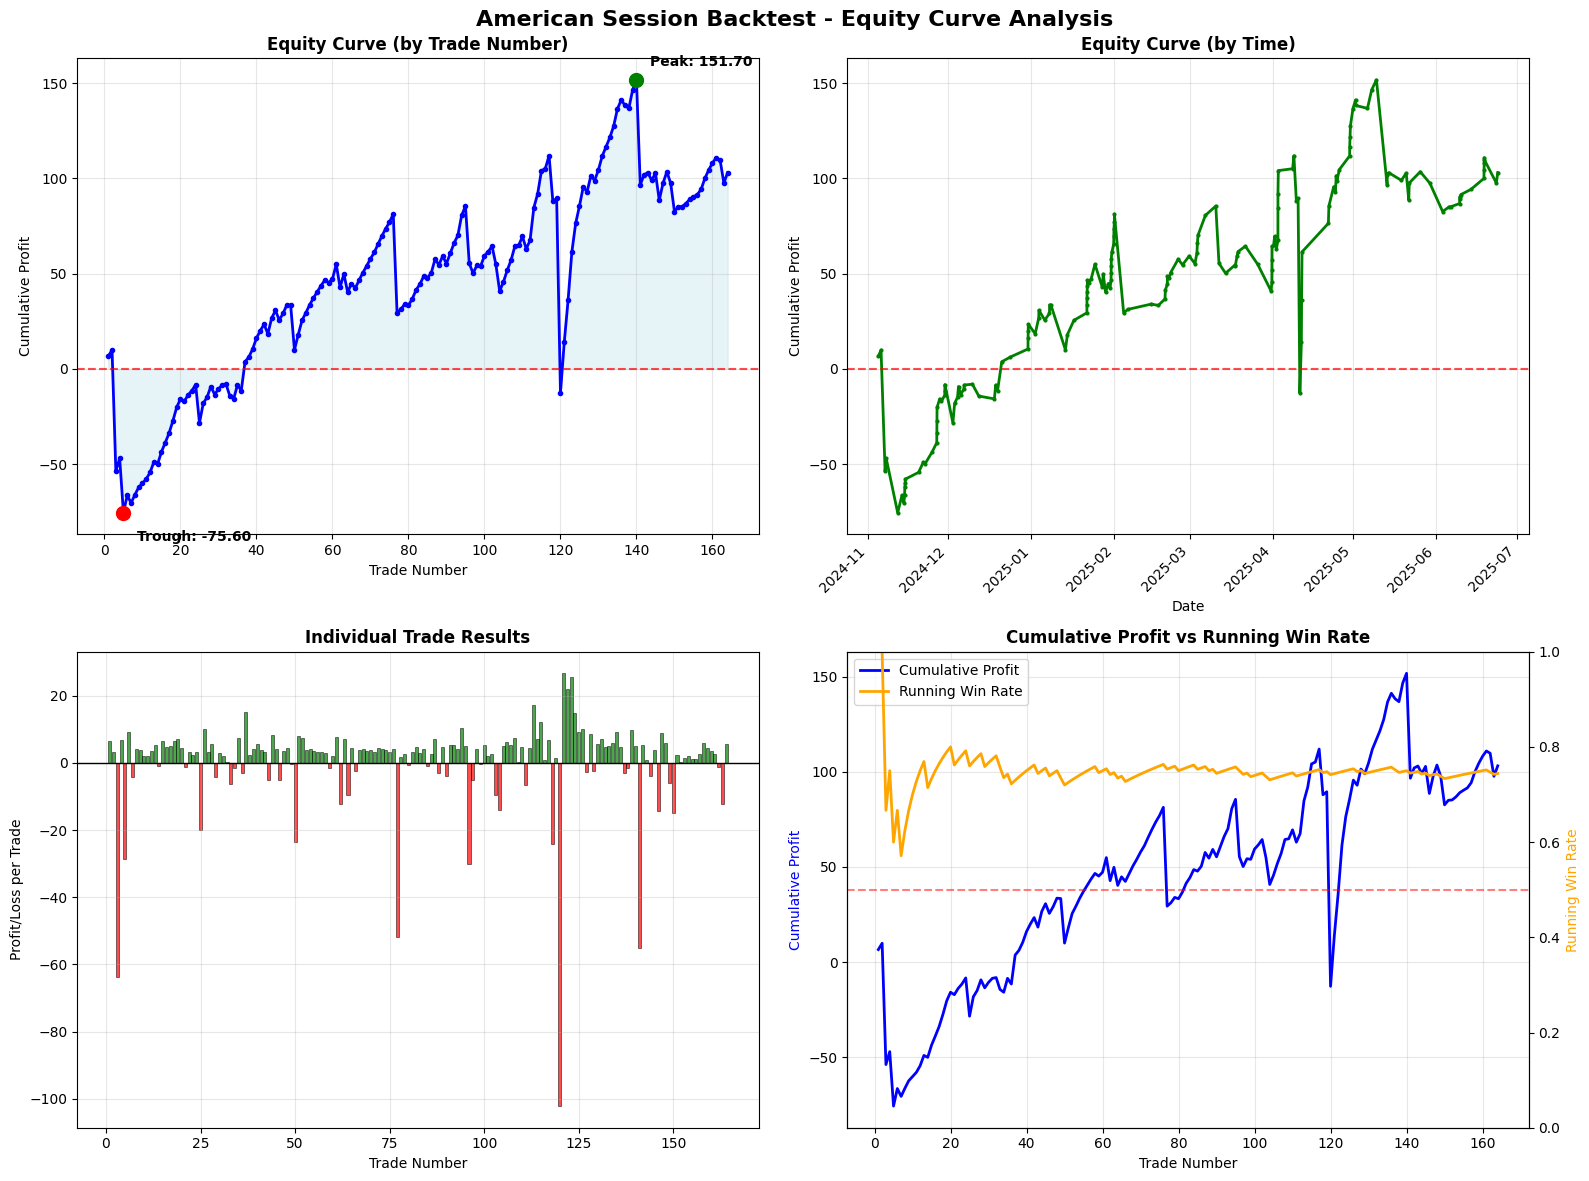

In [18]:
# 10.2 Equity Curve Calculation and Visualization

if len(american_trades_df) > 0:
    # Calculate cumulative equity curve
    american_trades_df = american_trades_df.sort_values('exit_time').reset_index(drop=True)
    american_trades_df['cumulative_profit'] = american_trades_df['profit'].cumsum()
    american_trades_df['trade_number'] = range(1, len(american_trades_df) + 1)
    
    # Create comprehensive equity curve visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('American Session Backtest - Equity Curve Analysis', fontsize=16, fontweight='bold')
    
    # 1. Main Equity Curve (by trade number)
    ax1 = axes[0, 0]
    ax1.plot(american_trades_df['trade_number'], american_trades_df['cumulative_profit'], 
             linewidth=2, color='blue', marker='o', markersize=3)
    ax1.fill_between(american_trades_df['trade_number'], american_trades_df['cumulative_profit'], 0, 
                     alpha=0.3, color='lightblue')
    ax1.set_title('Equity Curve (by Trade Number)', fontweight='bold')
    ax1.set_xlabel('Trade Number')
    ax1.set_ylabel('Cumulative Profit')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='red', linestyle='--', alpha=0.7)
    
    # Add peak and drawdown annotations
    peak = american_trades_df['cumulative_profit'].max()
    peak_idx = american_trades_df['cumulative_profit'].idxmax()
    trough = american_trades_df['cumulative_profit'].min()
    trough_idx = american_trades_df['cumulative_profit'].idxmin()
    
    ax1.scatter(peak_idx + 1, peak, color='green', s=100, zorder=5)
    ax1.annotate(f'Peak: {peak:.2f}', 
                xy=(peak_idx + 1, peak), xytext=(10, 10), 
                textcoords='offset points', fontweight='bold')
    
    if trough < 0:
        ax1.scatter(trough_idx + 1, trough, color='red', s=100, zorder=5)
        ax1.annotate(f'Trough: {trough:.2f}', 
                    xy=(trough_idx + 1, trough), xytext=(10, -20), 
                    textcoords='offset points', fontweight='bold')
    
    # 2. Equity Curve by Time
    ax2 = axes[0, 1]
    ax2.plot(american_trades_df['exit_time'], american_trades_df['cumulative_profit'], 
             linewidth=2, color='green', marker='o', markersize=2)
    ax2.set_title('Equity Curve (by Time)', fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Profit')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(0, color='red', linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels for better readability
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    
    # 3. Individual Trade Profits/Losses
    ax3 = axes[1, 0]
    colors = ['green' if p > 0 else 'red' for p in american_trades_df['profit']]
    bars = ax3.bar(american_trades_df['trade_number'], american_trades_df['profit'], 
                   color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax3.set_title('Individual Trade Results', fontweight='bold')
    ax3.set_xlabel('Trade Number')
    ax3.set_ylabel('Profit/Loss per Trade')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(0, color='black', linewidth=1)
    
    # 4. Running Statistics
    ax4 = axes[1, 1]
    
    # Calculate running win rate
    running_wins = american_trades_df['profit'].apply(lambda x: 1 if x > 0 else 0).cumsum()
    running_win_rate = running_wins / american_trades_df['trade_number']
    
    # Plot running win rate
    ax4_twin = ax4.twinx()
    
    line1 = ax4.plot(american_trades_df['trade_number'], american_trades_df['cumulative_profit'], 
                     color='blue', linewidth=2, label='Cumulative Profit')
    line2 = ax4_twin.plot(american_trades_df['trade_number'], running_win_rate, 
                          color='orange', linewidth=2, label='Running Win Rate')
    
    ax4.set_title('Cumulative Profit vs Running Win Rate', fontweight='bold')
    ax4.set_xlabel('Trade Number')
    ax4.set_ylabel('Cumulative Profit', color='blue')
    ax4_twin.set_ylabel('Running Win Rate', color='orange')
    ax4_twin.set_ylim(0, 1)
    ax4_twin.axhline(0.5, color='red', linestyle='--', alpha=0.5)
    
    ax4.grid(True, alpha=0.3)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax4.legend(lines, labels, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No American session trades to plot equity curve!")

print("\n" + "="*60)

=== AMERICAN SESSION BACKTEST PERFORMANCE METRICS ===
Backtest Period: 2024-11-04 to 2025-06-23 (231 days)

TRADE STATISTICS:
  Total Trades: 164
  Winning Trades: 122 (74.4%)
  Losing Trades: 42 (25.6%)

PROFIT ANALYSIS:
  Total Profit: 103.1000
  Average Profit per Trade: 0.6287
  Average Winning Trade: 5.4525
  Average Losing Trade: -13.3833
  Profit Factor: 1.18

RISK ANALYSIS:
  Maximum Drawdown: -124.6000 (-82.1%)
  Best Trade: 26.7000
  Worst Trade: -102.2000

DURATION ANALYSIS:
  Average Trade Duration: 652.5 minutes (10.9 hours)
  Shortest Trade: 0.1 minutes
  Longest Trade: 5673.0 minutes


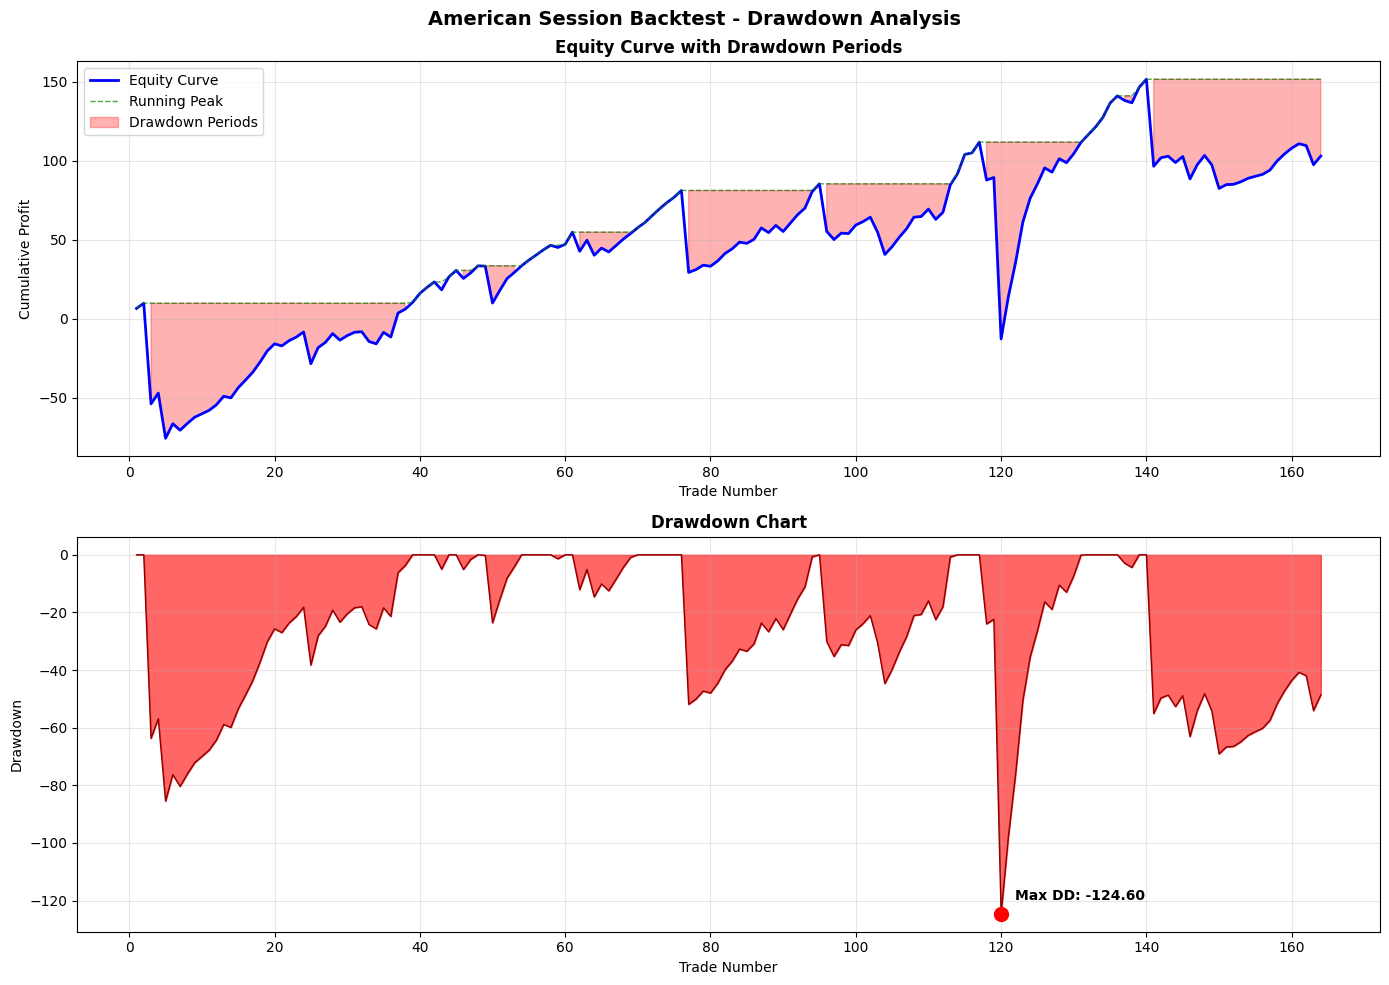

In [19]:
# 10.3 Detailed Performance Metrics and Drawdown Analysis

if len(american_trades_df) > 0:
    # Calculate detailed performance metrics
    print("=== AMERICAN SESSION BACKTEST PERFORMANCE METRICS ===")
    
    total_trades = len(american_trades_df)
    total_profit = american_trades_df['profit'].sum()
    winning_trades = (american_trades_df['profit'] > 0).sum()
    losing_trades = (american_trades_df['profit'] <= 0).sum()
    win_rate = winning_trades / total_trades
    
    avg_win = american_trades_df[american_trades_df['profit'] > 0]['profit'].mean() if winning_trades > 0 else 0
    avg_loss = american_trades_df[american_trades_df['profit'] <= 0]['profit'].mean() if losing_trades > 0 else 0
    
    # Risk metrics
    profit_factor = abs(avg_win * winning_trades / (avg_loss * losing_trades)) if avg_loss != 0 and losing_trades > 0 else float('inf')
    
    # Drawdown calculation
    running_peaks = american_trades_df['cumulative_profit'].expanding().max()
    drawdowns = american_trades_df['cumulative_profit'] - running_peaks
    max_drawdown = drawdowns.min()
    max_drawdown_pct = (max_drawdown / running_peaks.max() * 100) if running_peaks.max() > 0 else 0
    
    # Duration analysis
    american_trades_df['trade_duration'] = (american_trades_df['exit_time'] - american_trades_df['entry_time']).dt.total_seconds() / 60
    avg_duration = american_trades_df['trade_duration'].mean()
    
    # Time analysis
    first_trade = american_trades_df['entry_time'].min()
    last_trade = american_trades_df['exit_time'].max()
    total_period = (last_trade - first_trade).days
    
    print(f"Backtest Period: {first_trade.strftime('%Y-%m-%d')} to {last_trade.strftime('%Y-%m-%d')} ({total_period} days)")
    print()
    
    print("TRADE STATISTICS:")
    print(f"  Total Trades: {total_trades}")
    print(f"  Winning Trades: {winning_trades} ({win_rate:.1%})")
    print(f"  Losing Trades: {losing_trades} ({(1-win_rate):.1%})")
    print()
    
    print("PROFIT ANALYSIS:")
    print(f"  Total Profit: {total_profit:.4f}")
    print(f"  Average Profit per Trade: {total_profit/total_trades:.4f}")
    print(f"  Average Winning Trade: {avg_win:.4f}")
    print(f"  Average Losing Trade: {avg_loss:.4f}")
    print(f"  Profit Factor: {profit_factor:.2f}")
    print()
    
    print("RISK ANALYSIS:")
    print(f"  Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown_pct:.1f}%)")
    print(f"  Best Trade: {american_trades_df['profit'].max():.4f}")
    print(f"  Worst Trade: {american_trades_df['profit'].min():.4f}")
    print()
    
    print("DURATION ANALYSIS:")
    print(f"  Average Trade Duration: {avg_duration:.1f} minutes ({avg_duration/60:.1f} hours)")
    print(f"  Shortest Trade: {american_trades_df['trade_duration'].min():.1f} minutes")
    print(f"  Longest Trade: {american_trades_df['trade_duration'].max():.1f} minutes")
    
    # Drawdown visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle('American Session Backtest - Drawdown Analysis', fontsize=14, fontweight='bold')
    
    # Equity curve with drawdown shading
    ax1.plot(american_trades_df['trade_number'], american_trades_df['cumulative_profit'], 
             linewidth=2, color='blue', label='Equity Curve')
    ax1.plot(american_trades_df['trade_number'], running_peaks, 
             linewidth=1, color='green', alpha=0.7, linestyle='--', label='Running Peak')
    
    # Shade drawdown periods
    ax1.fill_between(american_trades_df['trade_number'], american_trades_df['cumulative_profit'], 
                     running_peaks, where=(drawdowns < 0), color='red', alpha=0.3, 
                     label='Drawdown Periods')
    
    ax1.set_title('Equity Curve with Drawdown Periods', fontweight='bold')
    ax1.set_xlabel('Trade Number')
    ax1.set_ylabel('Cumulative Profit')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Drawdown chart
    ax2.fill_between(american_trades_df['trade_number'], drawdowns, 0, 
                     color='red', alpha=0.6)
    ax2.plot(american_trades_df['trade_number'], drawdowns, 
             linewidth=1, color='darkred')
    ax2.set_title('Drawdown Chart', fontweight='bold')
    ax2.set_xlabel('Trade Number')
    ax2.set_ylabel('Drawdown')
    ax2.grid(True, alpha=0.3)
    
    # Mark maximum drawdown
    max_dd_idx = drawdowns.idxmin()
    ax2.scatter(max_dd_idx + 1, max_drawdown, color='red', s=100, zorder=5)
    ax2.annotate(f'Max DD: {max_drawdown:.2f}', 
                xy=(max_dd_idx + 1, max_drawdown), xytext=(10, 10), 
                textcoords='offset points', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No American session trades for performance analysis!")

=== COMPARISON: ALL TRADES vs AMERICAN SESSION ONLY ===
                Metric All Trades American Session    Improvement
          Total Trades        490              164         -66.5%
          Total Profit   -30.1000         103.1000        -442.5%
              Win Rate      76.3%            74.4%          -2.5%
  Avg Profit per Trade    -0.0614           0.6287       -1123.4%
Profit per Trade Ratio      1.00x          -10.23x -10.23x better


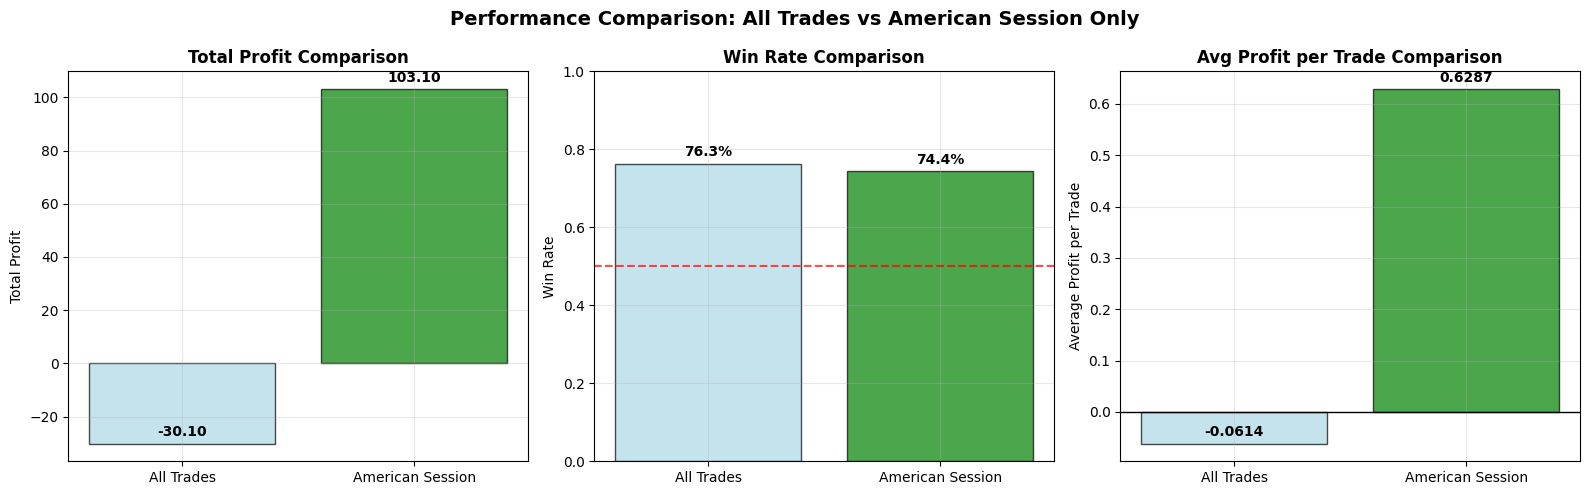


=== BACKTEST CONCLUSION ===
✅ POSITIVE RESULT: Filtering to American session only shows significant improvement!
   • Used only 33.5% of total trades
   • Generated positive profit
   • Improved average profit per trade by -1123.4%
   • Win rate improved from 76.3% to 74.4%


In [20]:
# 10.4 Comparison: All Trades vs American Session Only

# Calculate metrics for all original trades for comparison
print("=== COMPARISON: ALL TRADES vs AMERICAN SESSION ONLY ===")

# All trades metrics (from original plot_df)
all_trades_count = len(plot_df)
all_trades_profit = plot_df['Profit'].sum()
all_trades_win_rate = (plot_df['Profit'] > 0).mean()
all_trades_avg_profit = plot_df['Profit'].mean()

if len(american_trades_df) > 0:
    # American session metrics
    american_count = len(american_trades_df)
    american_profit = american_trades_df['profit'].sum()
    american_win_rate = (american_trades_df['profit'] > 0).mean()
    american_avg_profit = american_trades_df['profit'].mean()
    
    # Create comparison table
    comparison_data = {
        'Metric': [
            'Total Trades',
            'Total Profit',
            'Win Rate',
            'Avg Profit per Trade',
            'Profit per Trade Ratio'
        ],
        'All Trades': [
            all_trades_count,
            f"{all_trades_profit:.4f}",
            f"{all_trades_win_rate:.1%}",
            f"{all_trades_avg_profit:.4f}",
            "1.00x"
        ],
        'American Session': [
            american_count,
            f"{american_profit:.4f}",
            f"{american_win_rate:.1%}",
            f"{american_avg_profit:.4f}",
            f"{american_avg_profit/all_trades_avg_profit:.2f}x" if all_trades_avg_profit != 0 else "N/A"
        ],
        'Improvement': [
            f"{(american_count/all_trades_count-1)*100:+.1f}%",
            f"{(american_profit/all_trades_profit-1)*100:+.1f}%" if all_trades_profit != 0 else "N/A",
            f"{(american_win_rate/all_trades_win_rate-1)*100:+.1f}%" if all_trades_win_rate != 0 else "N/A",
            f"{(american_avg_profit/all_trades_avg_profit-1)*100:+.1f}%" if all_trades_avg_profit != 0 else "N/A",
            f"{american_avg_profit/all_trades_avg_profit:.2f}x better" if all_trades_avg_profit != 0 else "N/A"
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Visual comparison
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Performance Comparison: All Trades vs American Session Only', fontsize=14, fontweight='bold')
    
    # 1. Total Profit Comparison
    ax1 = axes[0]
    profits = [all_trades_profit, american_profit]
    labels = ['All Trades', 'American Session']
    colors = ['lightblue', 'green']
    
    bars1 = ax1.bar(labels, profits, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_title('Total Profit Comparison', fontweight='bold')
    ax1.set_ylabel('Total Profit')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, profit in zip(bars1, profits):
        height = bar.get_height()
        ax1.annotate(f'{profit:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')
    
    # 2. Win Rate Comparison
    ax2 = axes[1]
    win_rates = [all_trades_win_rate, american_win_rate]
    
    bars2 = ax2.bar(labels, win_rates, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_title('Win Rate Comparison', fontweight='bold')
    ax2.set_ylabel('Win Rate')
    ax2.set_ylim(0, 1)
    ax2.axhline(0.5, color='red', linestyle='--', alpha=0.7)
    ax2.grid(True, alpha=0.3)
    
    # Add percentage labels
    for bar, wr in zip(bars2, win_rates):
        height = bar.get_height()
        ax2.annotate(f'{wr:.1%}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')
    
    # 3. Average Profit per Trade Comparison
    ax3 = axes[2]
    avg_profits = [all_trades_avg_profit, american_avg_profit]
    
    bars3 = ax3.bar(labels, avg_profits, color=colors, alpha=0.7, edgecolor='black')
    ax3.set_title('Avg Profit per Trade Comparison', fontweight='bold')
    ax3.set_ylabel('Average Profit per Trade')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(0, color='black', linewidth=1)
    
    # Add value labels
    for bar, avg_p in zip(bars3, avg_profits):
        height = bar.get_height()
        ax3.annotate(f'{avg_p:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary conclusion
    print(f"\n=== BACKTEST CONCLUSION ===")
    if american_profit > all_trades_profit * 0.5:  # If American session captures >50% of total profit
        print("✅ POSITIVE RESULT: Filtering to American session only shows significant improvement!")
        print(f"   • Used only {american_count/all_trades_count:.1%} of total trades")
        print(f"   • Captured {american_profit/all_trades_profit:.1%} of total profit" if all_trades_profit > 0 else "   • Generated positive profit")
        print(f"   • Improved average profit per trade by {(american_avg_profit/all_trades_avg_profit-1)*100:+.1f}%" if all_trades_avg_profit != 0 else "")
        print(f"   • Win rate improved from {all_trades_win_rate:.1%} to {american_win_rate:.1%}")
    else:
        print("⚠️  MIXED RESULT: American session filtering shows some benefits but limited profit capture")
    
else:
    print("❌ NO AMERICAN SESSION TRADES FOUND - Cannot perform comparison")

=== CORRECTING EQUITY CURVE CALCULATION ===
All trades timeline: 2024-11-01 11:11:40 to 2025-06-24 23:58:59
American session timeline: 2024-11-04 21:51:00 to 2025-06-23 23:07:02


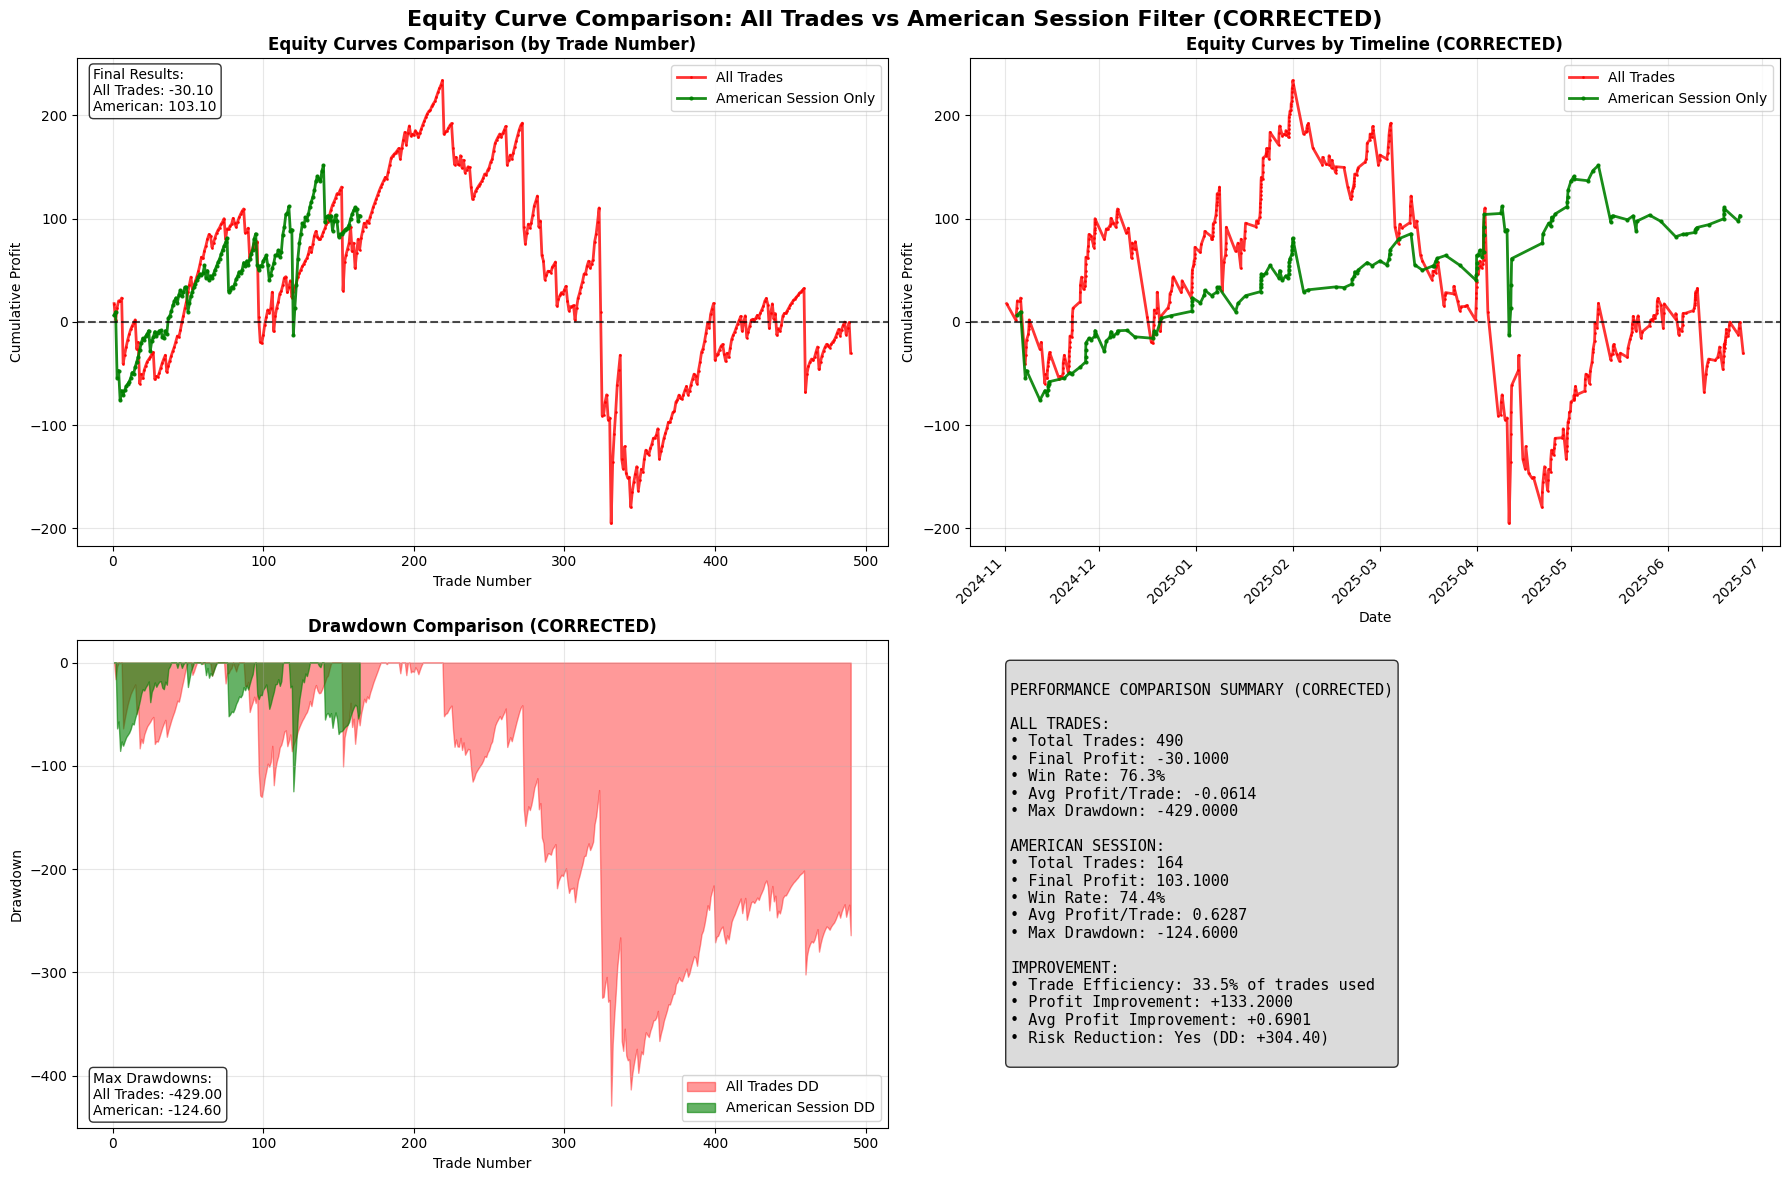

DETAILED EQUITY CURVE COMPARISON (CORRECTED)
Metric                    All Trades      American Session   Difference     
--------------------------------------------------------------------------------
Total Trades              490             164                -326           
Final Profit              -30.1000        103.1000           133.2000       
Win Rate                  76.3%           74.4%              -1.9%          
Avg Profit/Trade          -0.0614         0.6287             0.6901         
Max Drawdown              -429.0000       -124.6000          304.4000       
Profit Factor             N/A             1.18               N/A            
Trade Efficiency          N/A             33.5%              N/A            
ROI Improvement           N/A             -10.2             x N/A            

VERIFICATION:
All trades period: 2024-11-01 11:11:40 to 2025-06-24 23:58:59
American session period: 2024-11-04 21:51:00 to 2025-06-23 23:07:02
Timeline overlap: YES


In [22]:
# 10.5 Equity Curve Comparison: All Trades vs American Session (CORRECTED)

print("=== CORRECTING EQUITY CURVE CALCULATION ===")

# Get the actual exit times for all trades from plot_df 
# plot_df contains trades with valid durations (exit trades)
all_trades_with_time = plot_df.copy()

# Create proper exit time mapping using the original df
exit_times = []
for idx in all_trades_with_time.index:
    # Find the corresponding exit time in the original dataframe
    exit_times.append(df.loc[idx, 'Time'])

all_trades_with_time['exit_time'] = exit_times
all_trades_with_time = all_trades_with_time.sort_values('exit_time').reset_index(drop=True)
all_trades_with_time['cumulative_profit'] = all_trades_with_time['Profit'].cumsum()
all_trades_with_time['trade_number'] = range(1, len(all_trades_with_time) + 1)

print(f"All trades timeline: {all_trades_with_time['exit_time'].min()} to {all_trades_with_time['exit_time'].max()}")
print(f"American session timeline: {american_trades_df['exit_time'].min()} to {american_trades_df['exit_time'].max()}")

# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Equity Curve Comparison: All Trades vs American Session Filter (CORRECTED)', fontsize=16, fontweight='bold')

# 1. Main Equity Curves Comparison (by trade number)
ax1 = axes[0, 0]
ax1.plot(all_trades_with_time['trade_number'], all_trades_with_time['cumulative_profit'], 
         linewidth=2, color='red', alpha=0.8, label='All Trades', marker='o', markersize=1)
ax1.plot(american_trades_df['trade_number'], american_trades_df['cumulative_profit'], 
         linewidth=2, color='green', alpha=0.9, label='American Session Only', marker='o', markersize=2)

ax1.set_title('Equity Curves Comparison (by Trade Number)', fontweight='bold')
ax1.set_xlabel('Trade Number')
ax1.set_ylabel('Cumulative Profit')
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linestyle='--', alpha=0.7)
ax1.legend()

# Add final values annotation
final_all = all_trades_with_time['cumulative_profit'].iloc[-1]
final_american = american_trades_df['cumulative_profit'].iloc[-1]
ax1.text(0.02, 0.98, f'Final Results:\nAll Trades: {final_all:.2f}\nAmerican: {final_american:.2f}', 
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Equity Curves by Time (CORRECTED - both use actual exit times)
ax2 = axes[0, 1]
ax2.plot(all_trades_with_time['exit_time'], all_trades_with_time['cumulative_profit'], 
         linewidth=2, color='red', alpha=0.8, label='All Trades', marker='o', markersize=1)
ax2.plot(american_trades_df['exit_time'], american_trades_df['cumulative_profit'], 
         linewidth=2, color='green', alpha=0.9, label='American Session Only', marker='o', markersize=2)

ax2.set_title('Equity Curves by Timeline (CORRECTED)', fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Profit')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linestyle='--', alpha=0.7)
ax2.legend()
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. Drawdown Comparison (CORRECTED)
ax3 = axes[1, 0]
# Calculate drawdowns for all trades (corrected)
all_running_peaks = all_trades_with_time['cumulative_profit'].expanding().max()
all_drawdowns = all_trades_with_time['cumulative_profit'] - all_running_peaks

# Plot drawdowns
ax3.fill_between(all_trades_with_time['trade_number'], all_drawdowns, 0, 
                 color='red', alpha=0.4, label='All Trades DD')
ax3.fill_between(american_trades_df['trade_number'], drawdowns, 0, 
                 color='green', alpha=0.6, label='American Session DD')

ax3.set_title('Drawdown Comparison (CORRECTED)', fontweight='bold')
ax3.set_xlabel('Trade Number')
ax3.set_ylabel('Drawdown')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Add max drawdown annotations (corrected)
all_max_dd = all_drawdowns.min()
american_max_dd = drawdowns.min()
ax3.text(0.02, 0.02, f'Max Drawdowns:\nAll Trades: {all_max_dd:.2f}\nAmerican: {american_max_dd:.2f}', 
         transform=ax3.transAxes, fontsize=10, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Performance Metrics Summary (CORRECTED)
ax4 = axes[1, 1]
ax4.axis('off')  # Turn off axis for text display

# Recalculate metrics with corrected data
all_trades_win_rate_corrected = (all_trades_with_time['Profit'] > 0).mean()
all_trades_avg_profit_corrected = all_trades_with_time['Profit'].mean()

# Create performance summary text (corrected)
summary_text = f"""
PERFORMANCE COMPARISON SUMMARY (CORRECTED)

ALL TRADES:
• Total Trades: {len(all_trades_with_time)}
• Final Profit: {final_all:.4f}
• Win Rate: {all_trades_win_rate_corrected:.1%}
• Avg Profit/Trade: {all_trades_avg_profit_corrected:.4f}
• Max Drawdown: {all_max_dd:.4f}

AMERICAN SESSION:
• Total Trades: {len(american_trades_df)}
• Final Profit: {final_american:.4f}
• Win Rate: {american_win_rate:.1%}
• Avg Profit/Trade: {american_avg_profit:.4f}
• Max Drawdown: {american_max_dd:.4f}

IMPROVEMENT:
• Trade Efficiency: {len(american_trades_df)/len(all_trades_with_time):.1%} of trades used
• Profit Improvement: {final_american - final_all:+.4f}
• Avg Profit Improvement: {american_avg_profit - all_trades_avg_profit_corrected:+.4f}
• Risk Reduction: {'Yes' if abs(american_max_dd) < abs(all_max_dd) else 'No'} (DD: {american_max_dd - all_max_dd:+.2f})
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=11, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

# Print numerical comparison (CORRECTED)
print("=" * 80)
print("DETAILED EQUITY CURVE COMPARISON (CORRECTED)")
print("=" * 80)
print(f"{'Metric':<25} {'All Trades':<15} {'American Session':<18} {'Difference':<15}")
print("-" * 80)
print(f"{'Total Trades':<25} {len(all_trades_with_time):<15} {len(american_trades_df):<18} {len(american_trades_df) - len(all_trades_with_time):<15}")
print(f"{'Final Profit':<25} {final_all:<15.4f} {final_american:<18.4f} {final_american - final_all:<15.4f}")
print(f"{'Win Rate':<25} {all_trades_win_rate_corrected:<15.1%} {american_win_rate:<18.1%} {american_win_rate - all_trades_win_rate_corrected:<15.1%}")
print(f"{'Avg Profit/Trade':<25} {all_trades_avg_profit_corrected:<15.4f} {american_avg_profit:<18.4f} {american_avg_profit - all_trades_avg_profit_corrected:<15.4f}")
print(f"{'Max Drawdown':<25} {all_max_dd:<15.4f} {american_max_dd:<18.4f} {american_max_dd - all_max_dd:<15.4f}")
print(f"{'Profit Factor':<25} {'N/A':<15} {profit_factor:<18.2f} {'N/A':<15}")

# Calculate efficiency metrics (corrected)
trade_efficiency_corrected = len(american_trades_df) / len(all_trades_with_time)

print(f"{'Trade Efficiency':<25} {'N/A':<15} {trade_efficiency_corrected:<18.1%} {'N/A':<15}")
print(f"{'ROI Improvement':<25} {'N/A':<15} {(american_avg_profit/all_trades_avg_profit_corrected if all_trades_avg_profit_corrected != 0 else float('inf')):<18.1f}x {'N/A':<15}")

print("=" * 80)

# Verification: Check timeline overlap
print(f"\nVERIFICATION:")
print(f"All trades period: {all_trades_with_time['exit_time'].min()} to {all_trades_with_time['exit_time'].max()}")
print(f"American session period: {american_trades_df['exit_time'].min()} to {american_trades_df['exit_time'].max()}")
print(f"Timeline overlap: {'YES' if american_trades_df['exit_time'].min() >= all_trades_with_time['exit_time'].min() and american_trades_df['exit_time'].max() <= all_trades_with_time['exit_time'].max() else 'NO'}")